# Proyecto 1 - Señales y Sistemas I

### Estudiante: Diego Alfaro Segura (C20259)


# Configuración del Programa
Primero, se importan todas las librerías necesarias para el código.

In [151]:
import numpy as np
import random as rd
import wave
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.signal import butter, lfilter, filtfilt
from statistics import stdev
sys.path.insert(1, r'./../functions')

# Tamaño de letra para títulos.
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.4

# Función de información de señales

Se crea una función la cual permite extraer parámetros y datos de las señales. [1]

In [152]:
def ecg(variable):
    record = wave.open(variable, 'r') # Se cargan los datos.

    # Se obtienen parámetros de la onda.
    numChannels = record.getnchannels() 
    numFrames = record.getnframes()
    sampleRate = record.getframerate()
    sampleWidth = record.getsampwidth()
    
    # Se obtienen datos de la onda.
    dstr = record.readframes(numFrames * numChannels)
    waveData = np.frombuffer(dstr, np.int16)

    # Se obtiene el intervalo de tiempo.
    timeECG = np.linspace(0, len(waveData)/sampleRate, num=len(waveData))

    return timeECG, waveData

# Graficación de las ondas.

Se extraen los datos de cada onda seleccionada, y se grafican dichos datos en términos del tiempo, para cada señal dada.

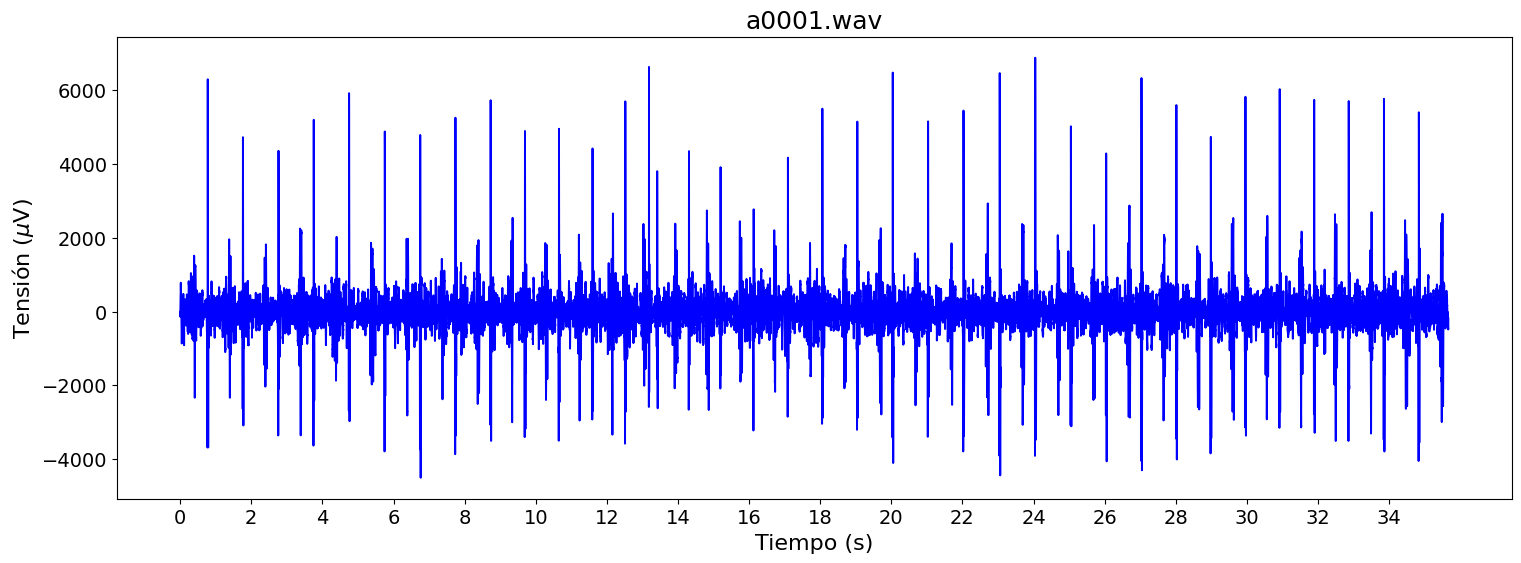

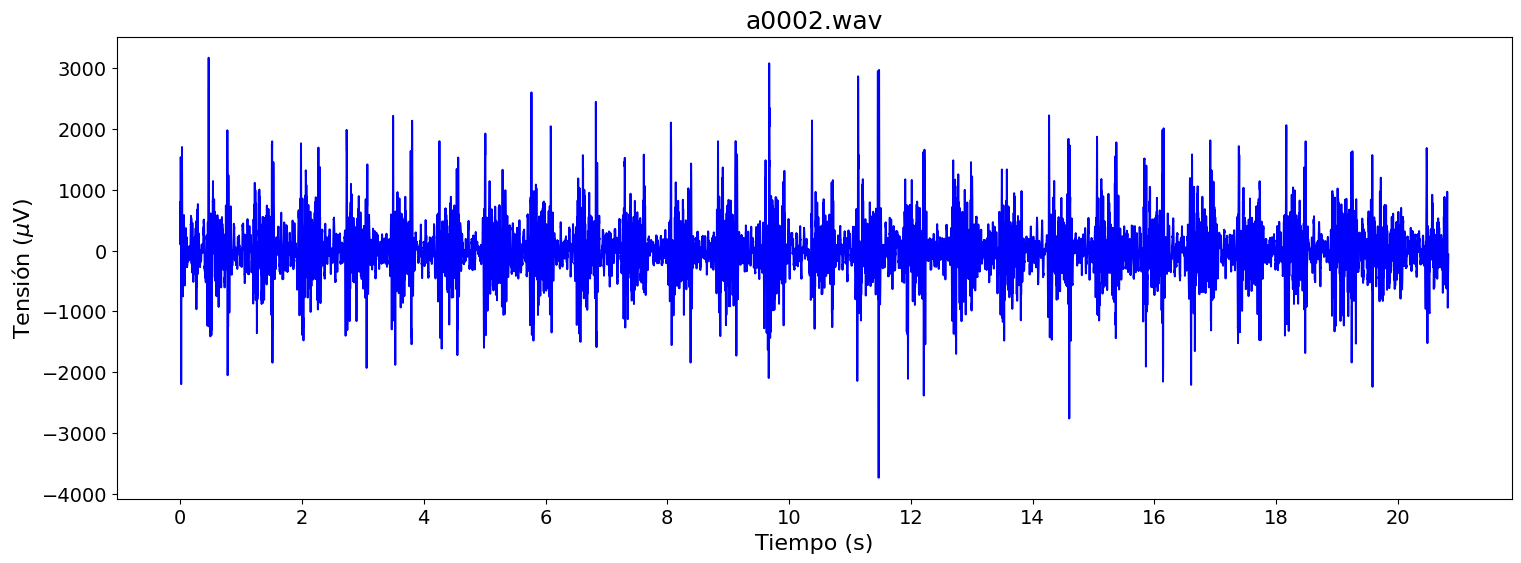

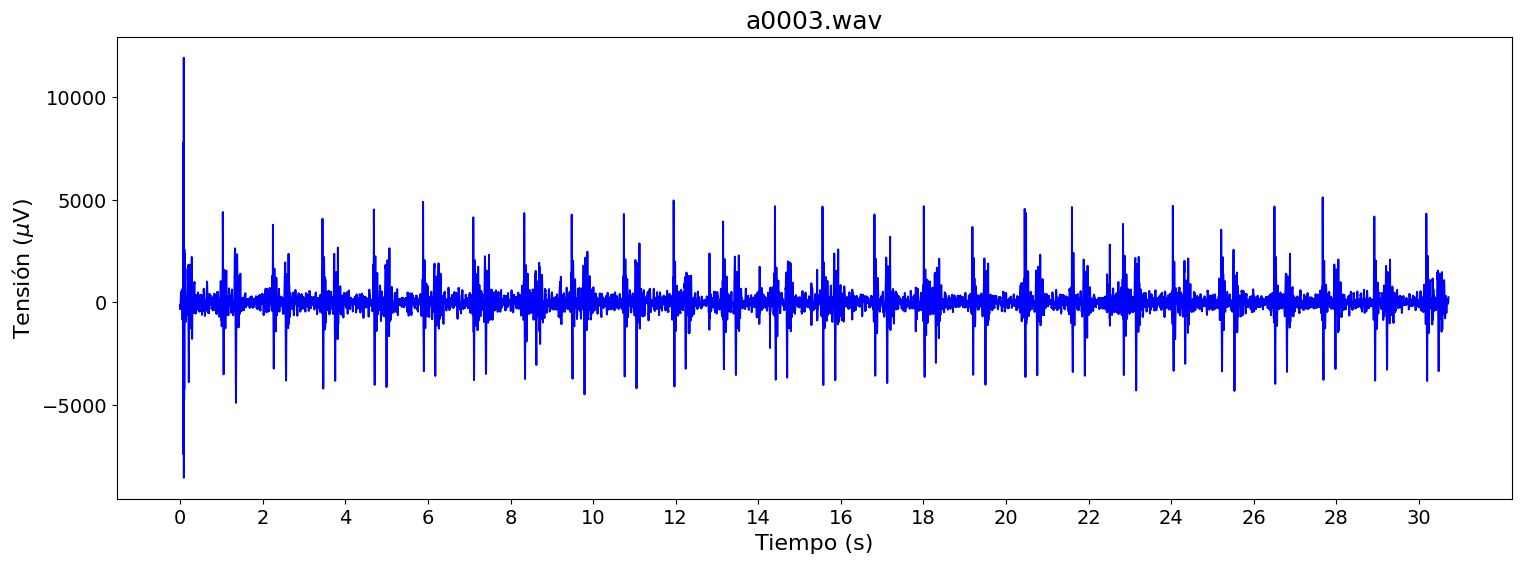

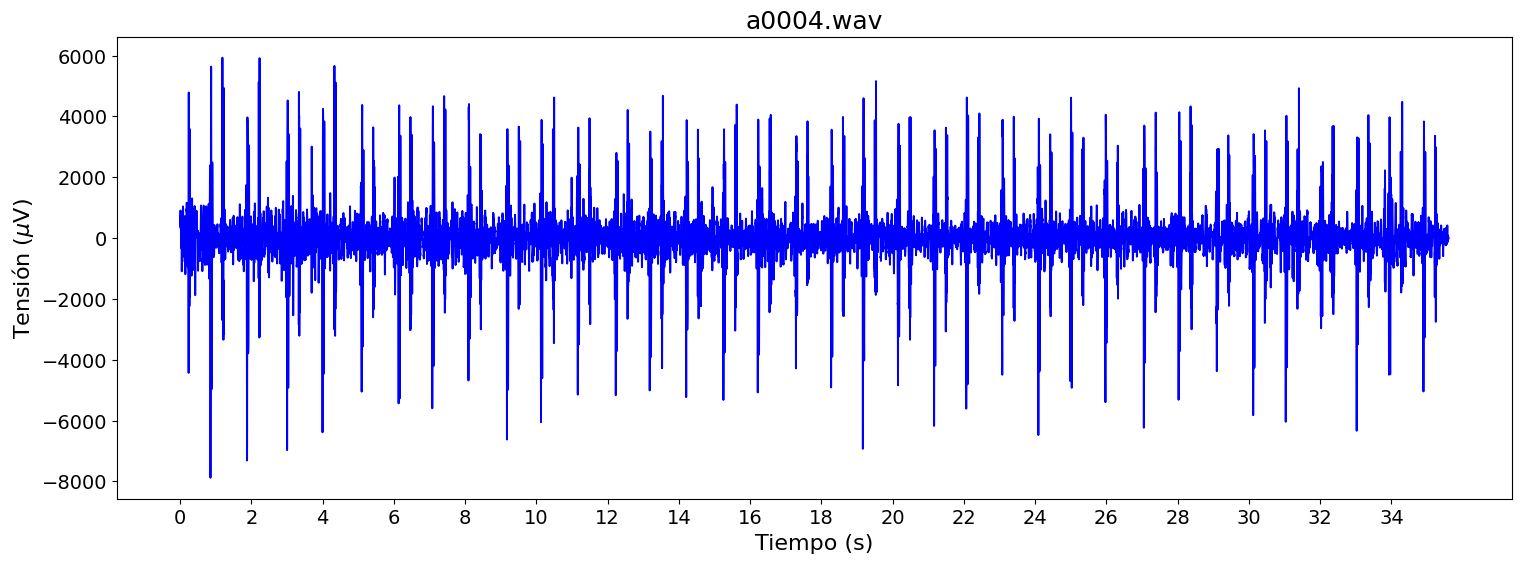

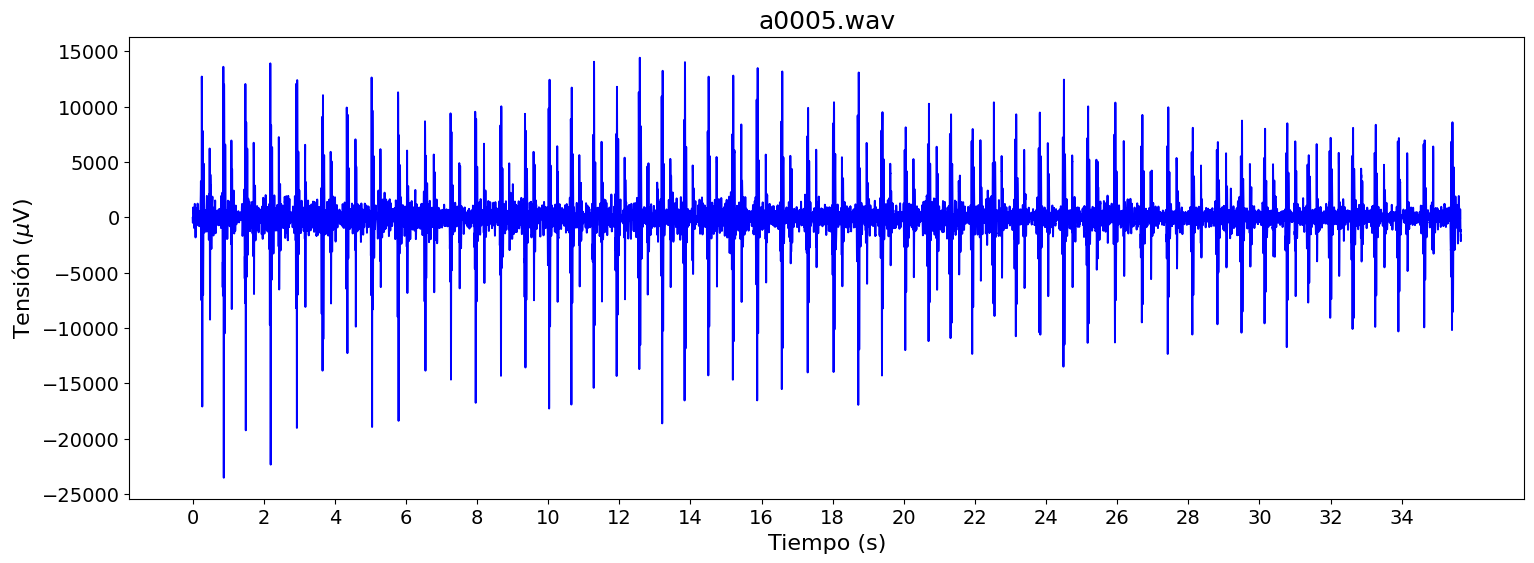

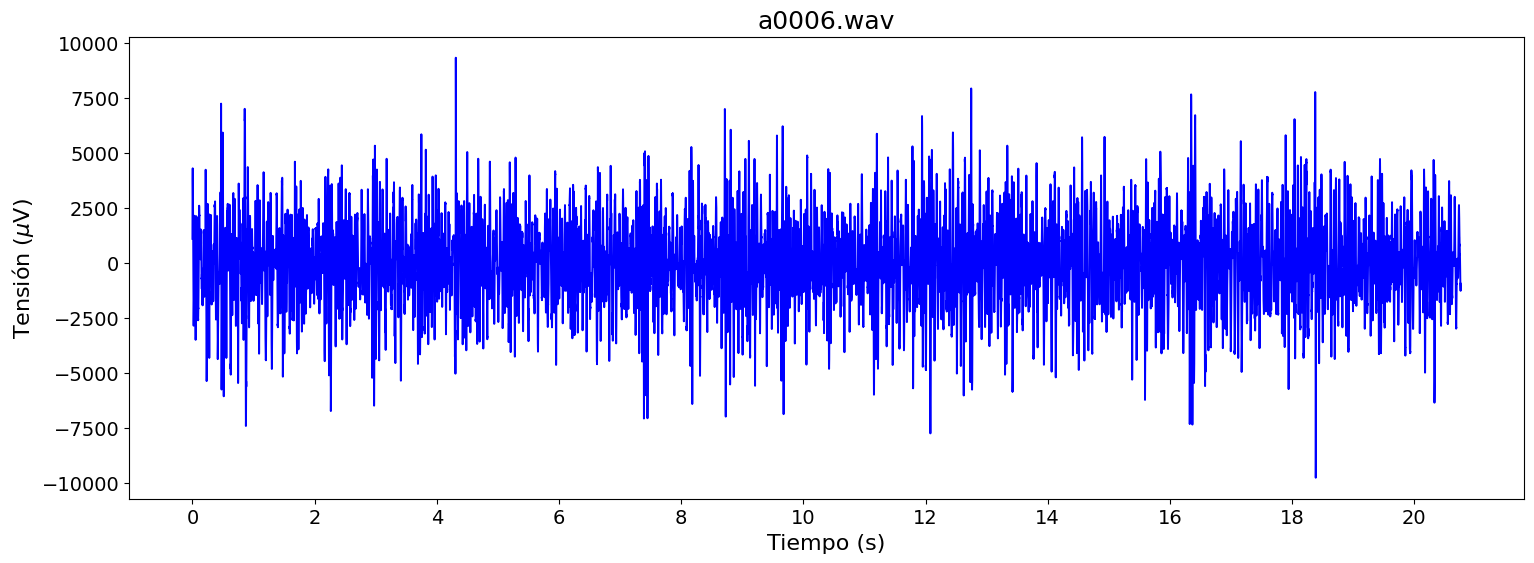

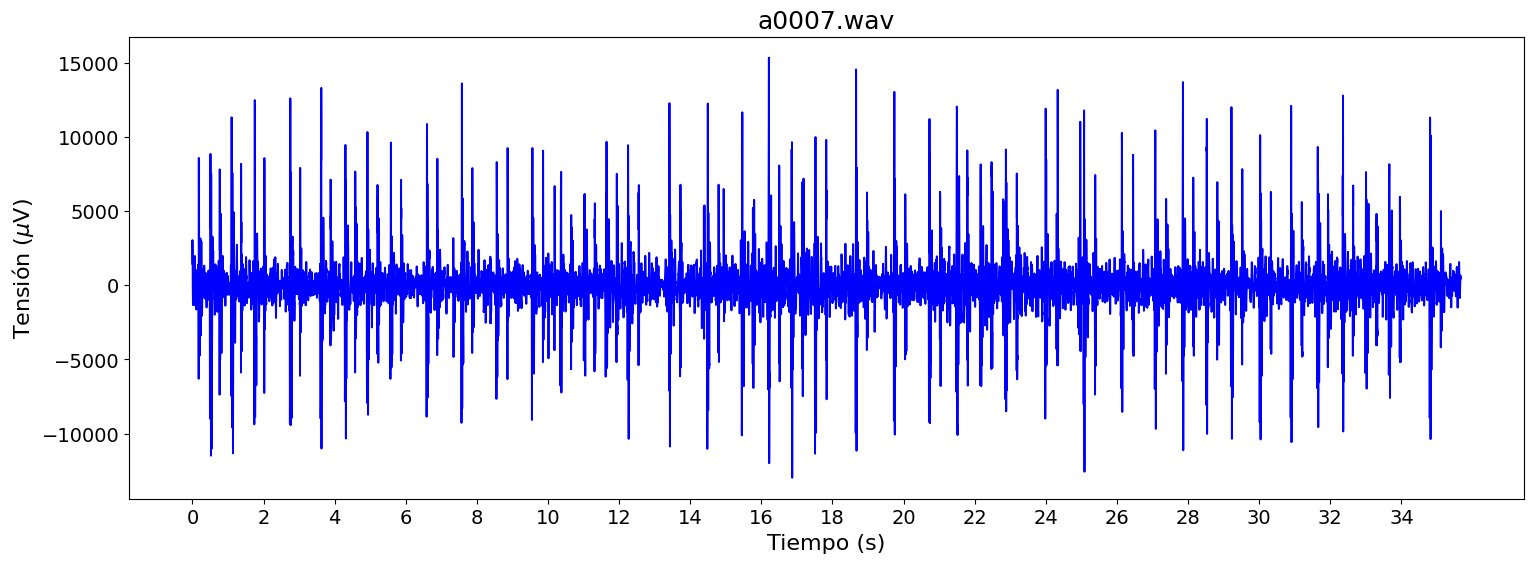

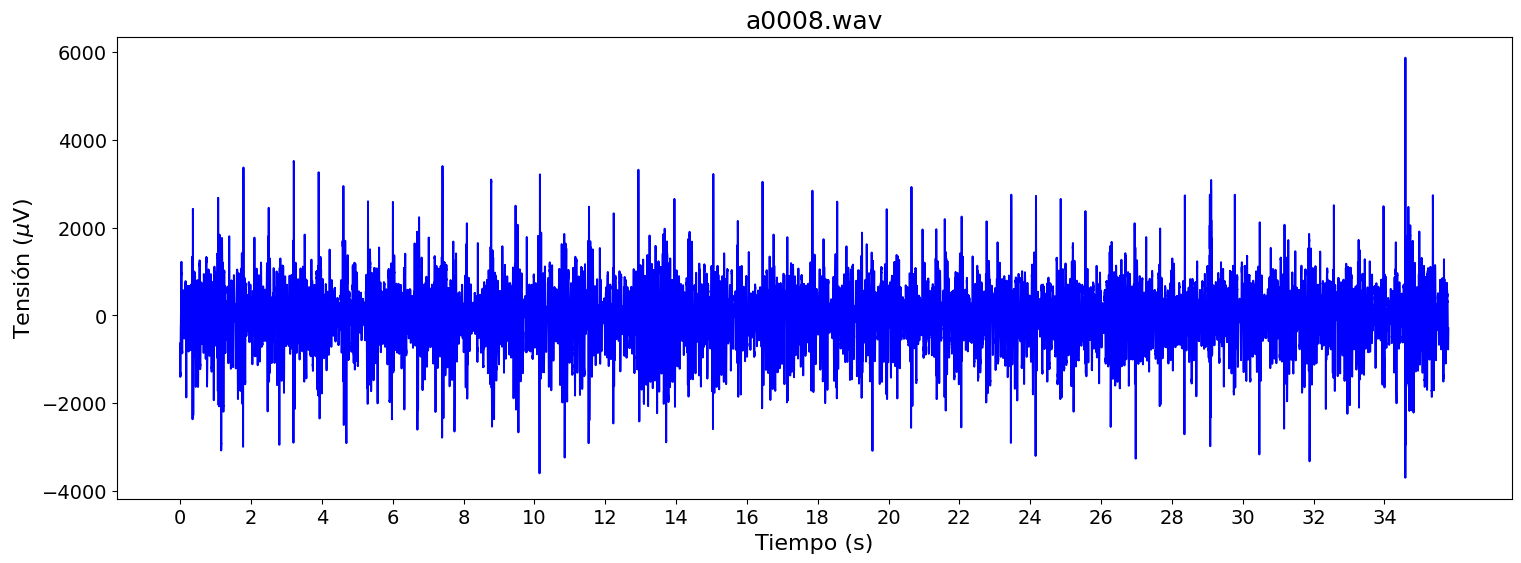

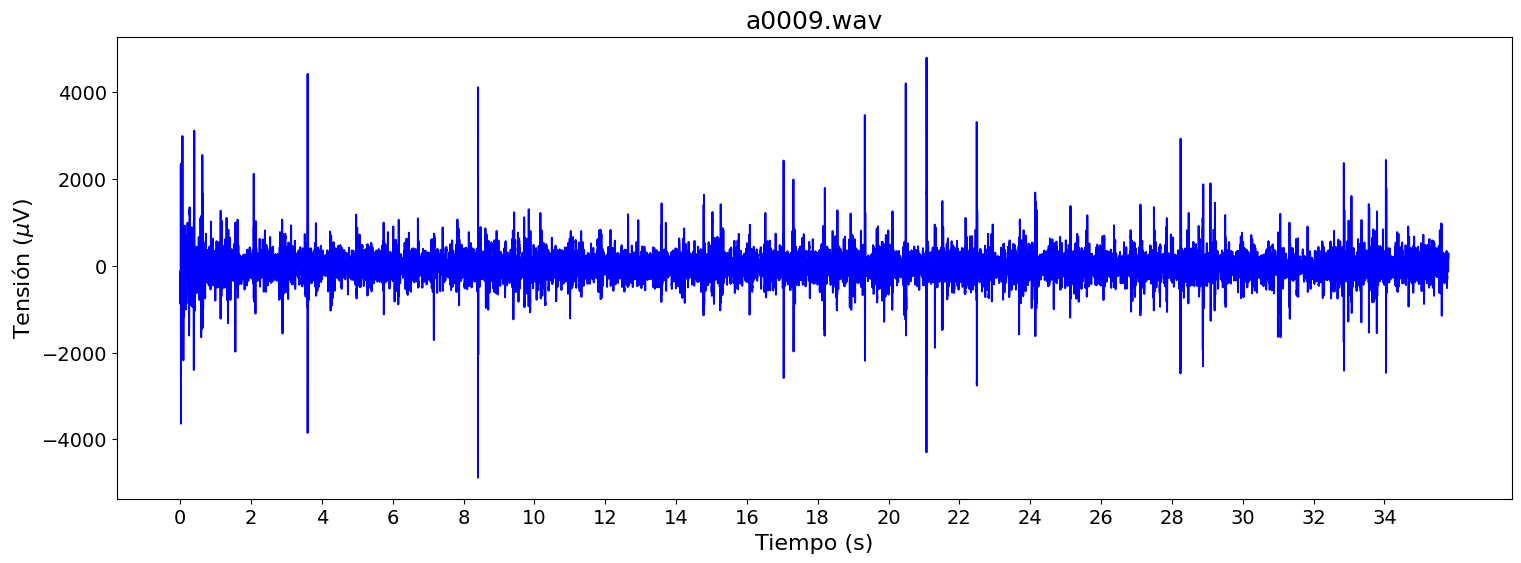

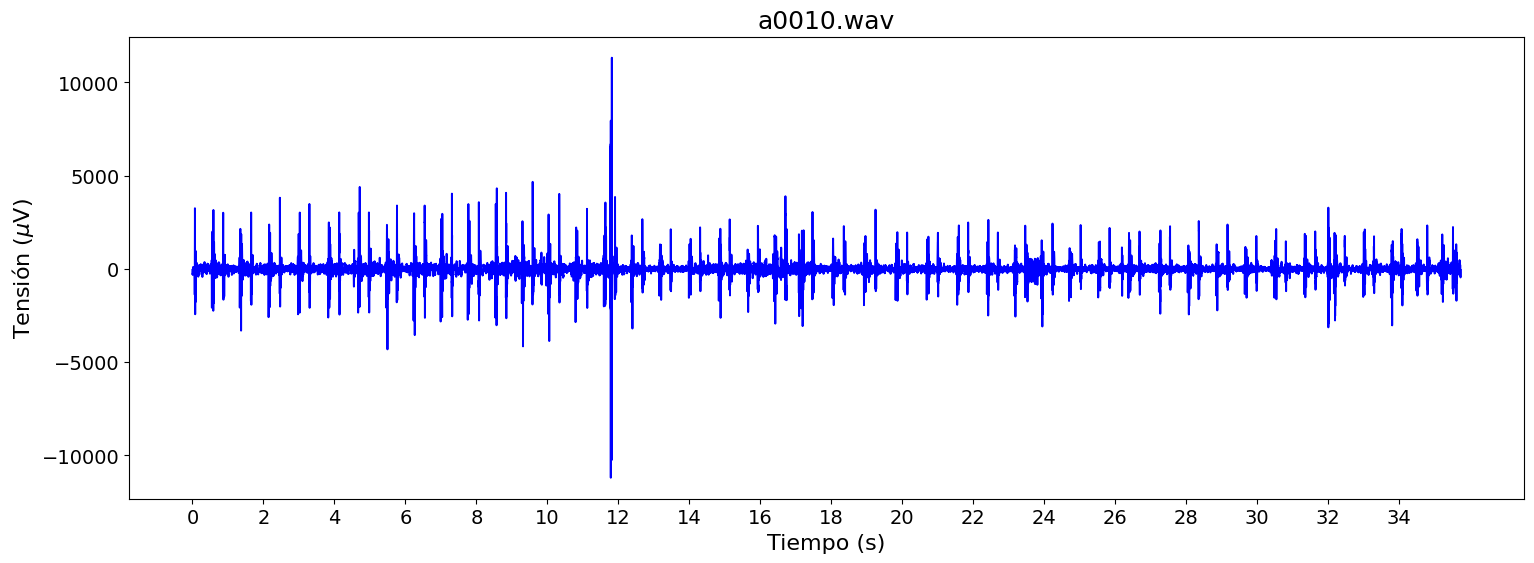

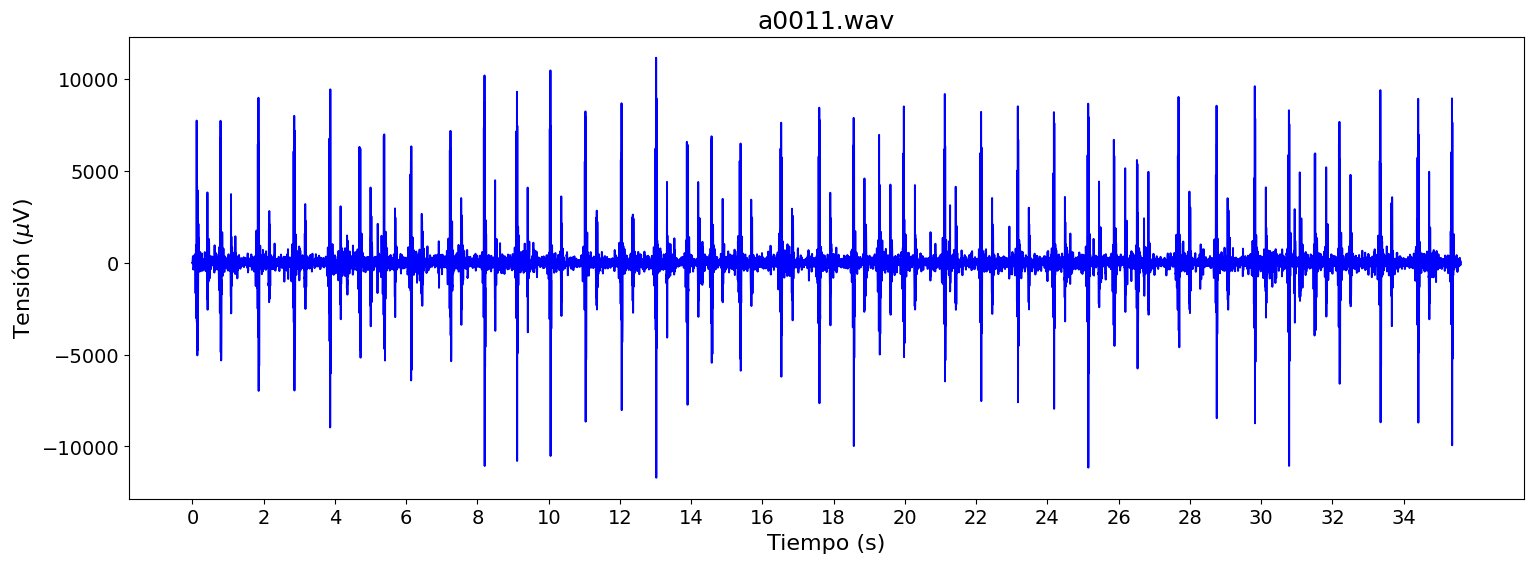

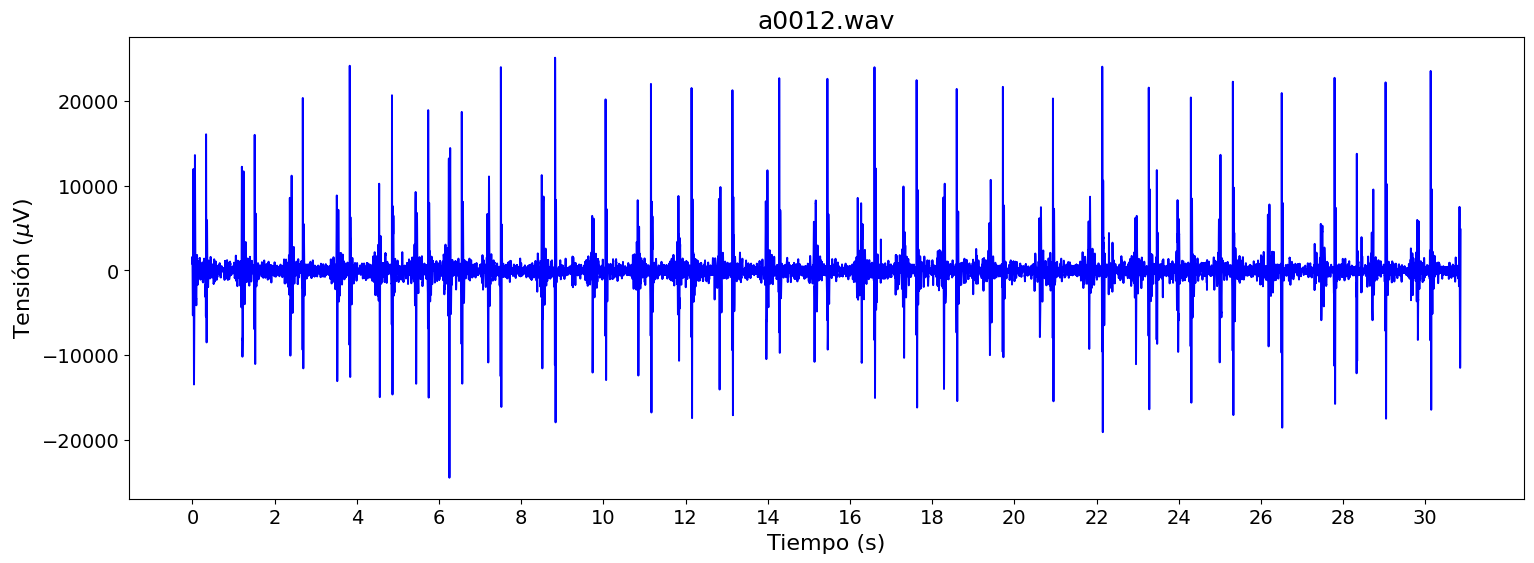

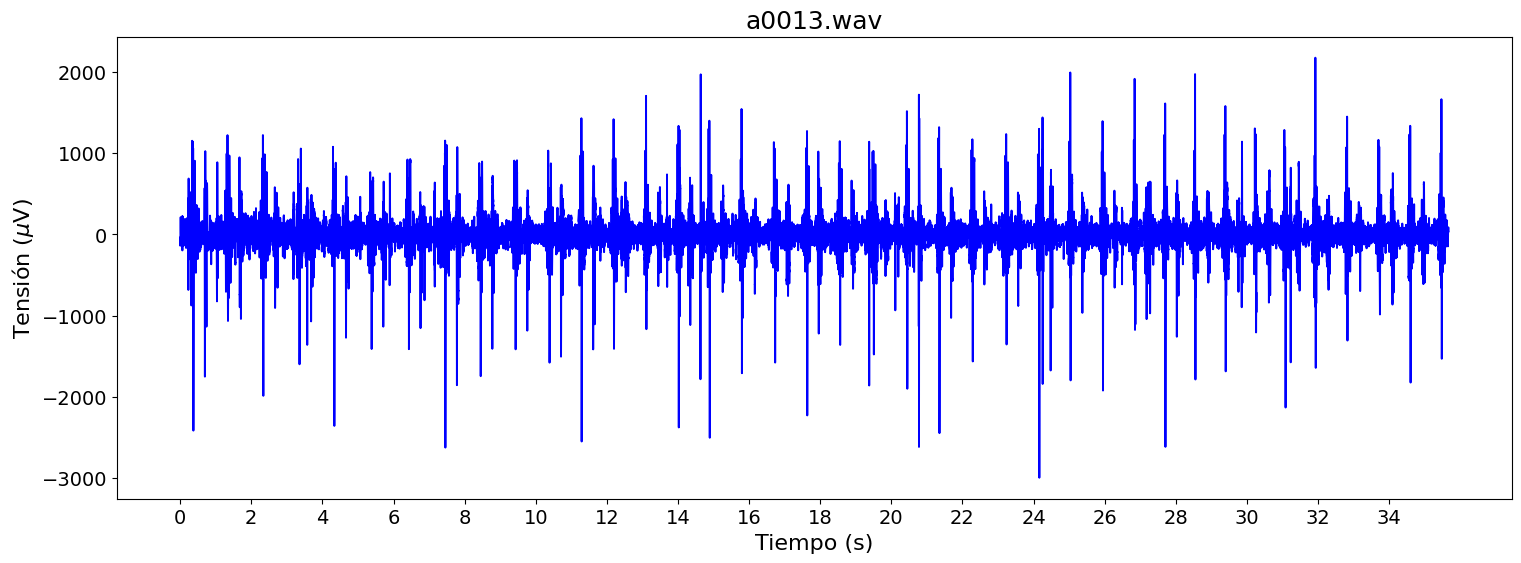

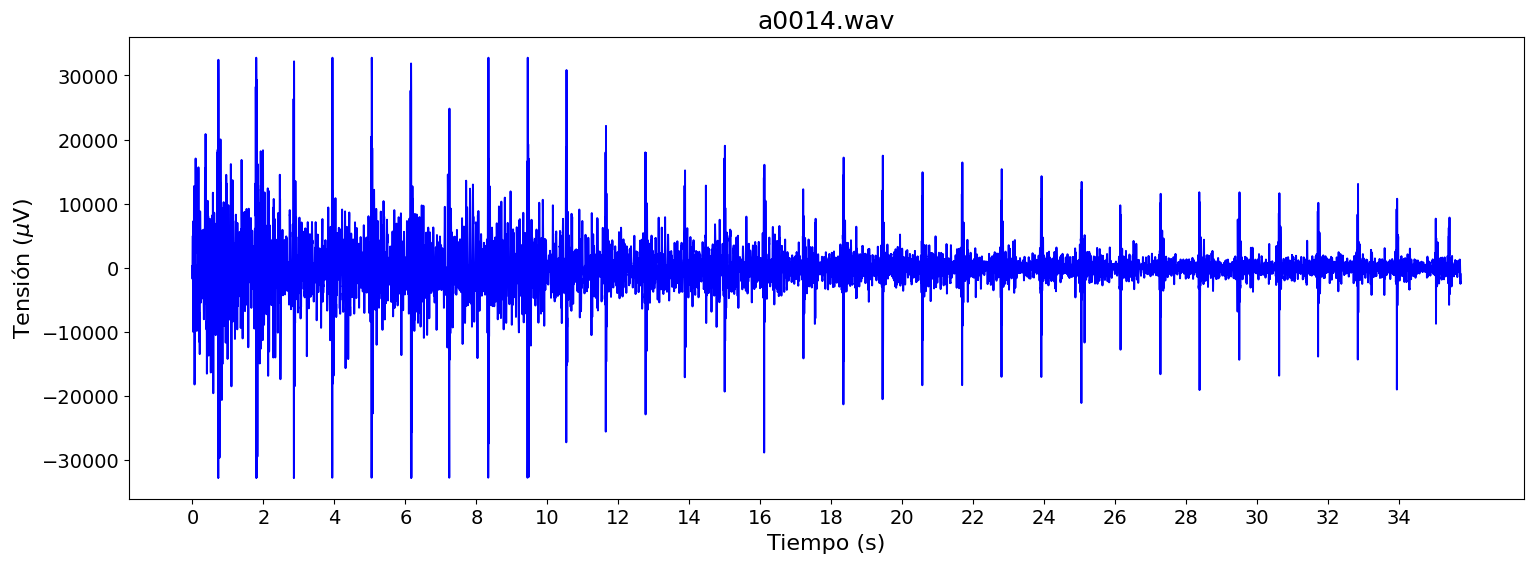

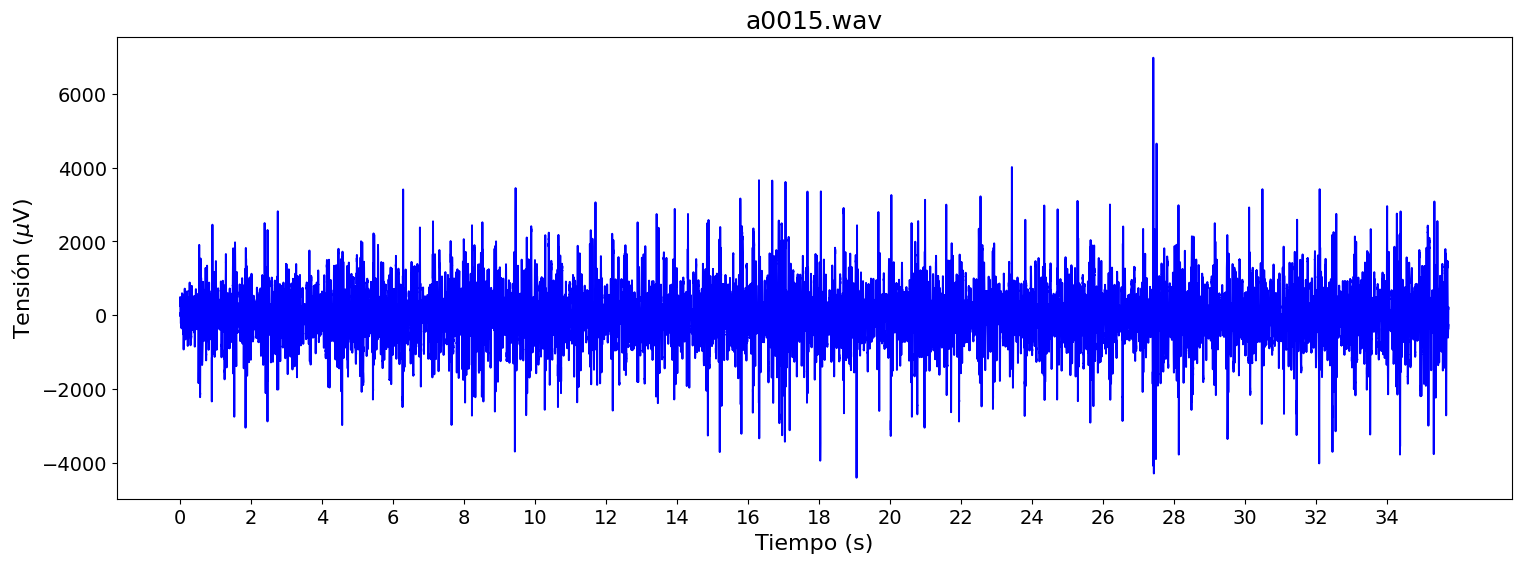

In [153]:
ondas = ["a00" + str(x).zfill(2) for x in range(1,16)] # Se establecen los nombres de los archivos.

for i in range(0, len(ondas)):
    timeECG, waveData = ecg(ondas[i]+'.wav')
    
    # Se grafican los datos "waveData", en función del tiempo "timeECG".
    plt.figure(figsize=(18,6))
    plt.xlabel(r'Tiempo (s)')
    plt.ylabel(r'Tensión ($\mu$V)')
    plt.plot(timeECG,waveData, 'b')
    plt.title(ondas[i]+'.wav')
    plt.xticks(np.arange(0,max(timeECG),2)) # Se agregan más marcas en el eje de tiempo.
    plt.show()

# Visualización de latidos.

Se escoge una señal, y se grafica un solo latido y tres latidos por aparte.

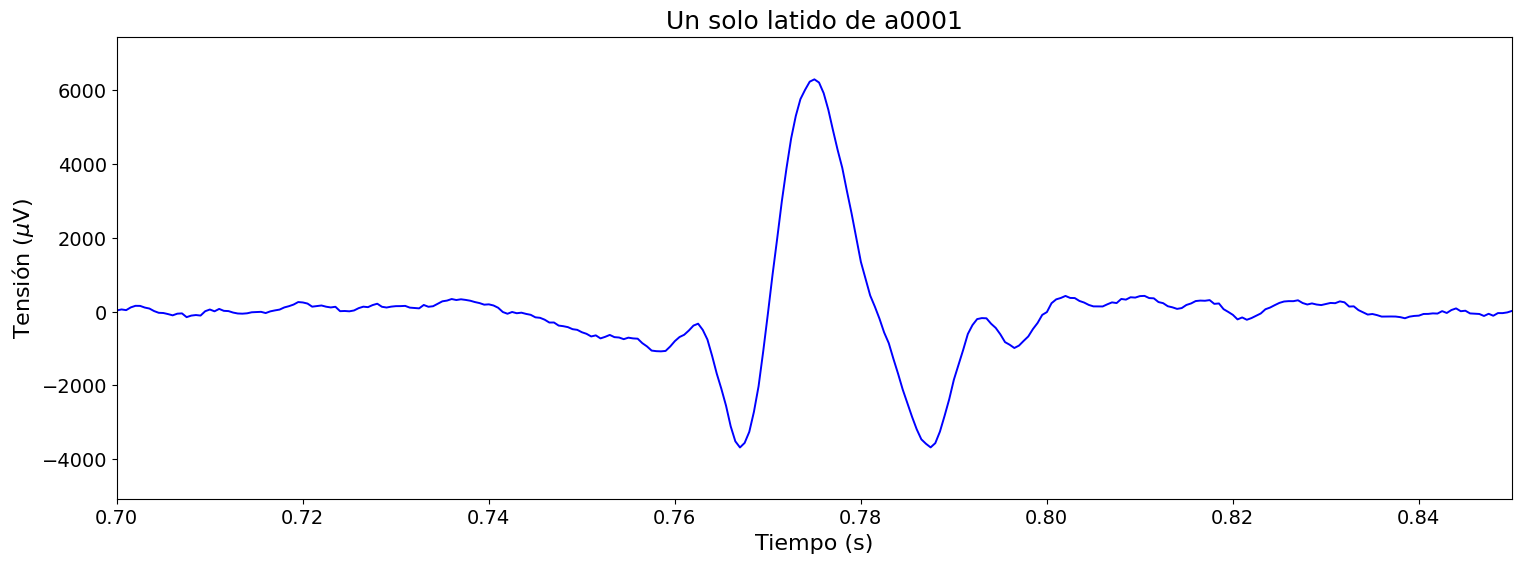

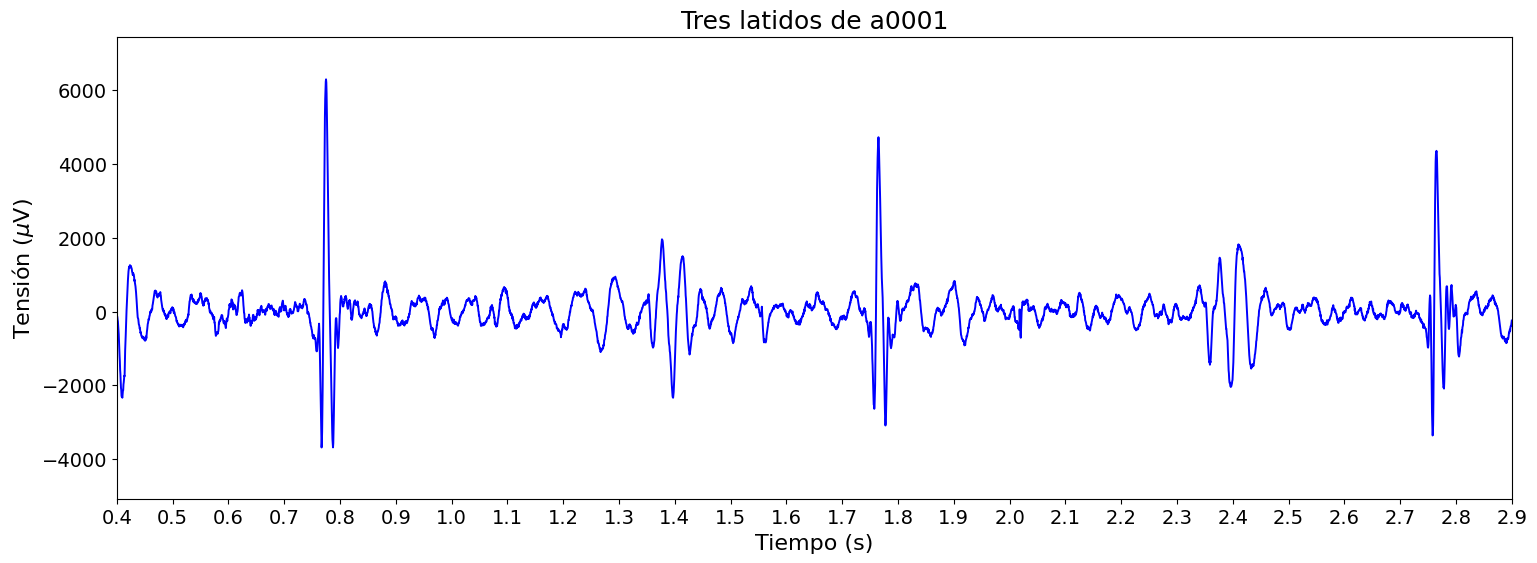

In [154]:
# Se obtienen los datos de una misma onda.
timeECG, waveData = ecg("a0001.wav")

# Se grafica un solo latido.
plt.figure(figsize=(18,6))
plt.xlabel(r'Tiempo (s)')
plt.ylabel(r'Tensión ($\mu$V)')
plt.plot(timeECG,waveData, 'b')
plt.xlim(.7,0.85)
plt.title("Un solo latido de a0001")
plt.show()

# Se grafican tres latidos.
plt.figure(figsize=(18,6))
plt.xlabel(r'Tiempo (s)')
plt.ylabel(r'Tensión ($\mu$V)')
plt.plot(timeECG,waveData, 'b')
plt.xlim(.40,2.9)
plt.xticks(np.arange(0.4,3,step=0.1))
plt.title("Tres latidos de a0001")
plt.show()

# Parte 2

##### Se emplean funciones para determinar la frecuencia cardiaca de los latidos presentes en las señales. Para lograr esto, las señales deben tener:
#####     - Una base estable
#####     - Valores máximos (R) mayores a valores de rebote (T)
#####     - Picos de valores máximos (R) de misma amplitud cada ciclo

##### Por esto, es conveniente recortar la señal a intervalos clave:

In [155]:
# Se establecen los intervalos de tiempo más limpios/claros de las señales [n1:n2].

n1_s = [30.1, 1.6, 2, 10.9, 10.2, 8, 13, 3.1, 19, 24.8, 21.9, 10.3, 25.7, 18.4, 24]
# Se hace una conversión necesaria para indexar el segundo n1_s buscado. 
# Es una aproximación basada en la frecuencia de toma de datos encontrada dentro de timeECG.
n1 = [int(i*2000) for i in n1_s]

n2_s = [34, 3.7, 10.3, 14.9, 14, 14, 16, 5.2, 22, 27.9, 25, 13.3, 30, 24, 25.4]
n2 = [int(i*2000) for i in n2_s]

# Aquí se precisó experimentalmente el threshold_ratio óptimo para cada señal.
# Esto permite que solo se registren los puntos máximos (R) de la señal recortada.
t = [0.7, 0.8, 0.77, 0.87, 0.91, 0.83, 0.77, 0.77, 0.7, 0.87, 0.97, 0.7, 0.85, 0.87, 0.83]

# Detección de picos (R)

Se establece una función que detecte los picos de la señal dada. [1]

In [156]:
def detecta_maximos_locales(timeECG, waveData, threshold_ratio=0.7):
    # If not all the R peaks are detected, lower the threshold_ratio
    # If components that are not R peaks (like T waves) are detected, up the threshold_ratio

    if len(timeECG) != len(waveData): #Raises an error if two arrays have different lengths
        raise Exception("The two arrays have different lengths.")
    
    interval = int(max(waveData)) - int(min(waveData))  # Se convirtieron los valores a enteros para resolver errores.
    threshold = threshold_ratio*interval + min(waveData)
    maxima = []
    maxima_indices = []
    mxs_indices = []
    banner = False
    
    for i in range(0, len(waveData)):
            
        if waveData[i] >= threshold:#If a threshold value is surpassed,
            # the indices and values are saved 
            banner = True
            maxima_indices.append(i)
            maxima.append(waveData[i])
            
        elif banner == True and waveData[i] < threshold: #If the threshold value is crossed
            # the index of the maximum value in the original array is saved
            index_local_max = maxima.index(max(maxima))
            mxs_indices.append(maxima_indices[index_local_max])
            maxima = []
            maxima_indices = []
            banner = False     

    return mxs_indices

# Picos de gráficas recortadas
##### Se grafican los datos "waveData", en función del tiempo "timeECG" para cada señal dada con marcas para cada punto máximo (R).
##### Se nota que algunas de las gráficas no son tan limpias/exactas como otras. Esto es pues la señal dada no presenta un comportamiento favorable, ya sea que no cumple las condiciones ya mencionadas al inicio de la sección, o que poseen mucho ruido.

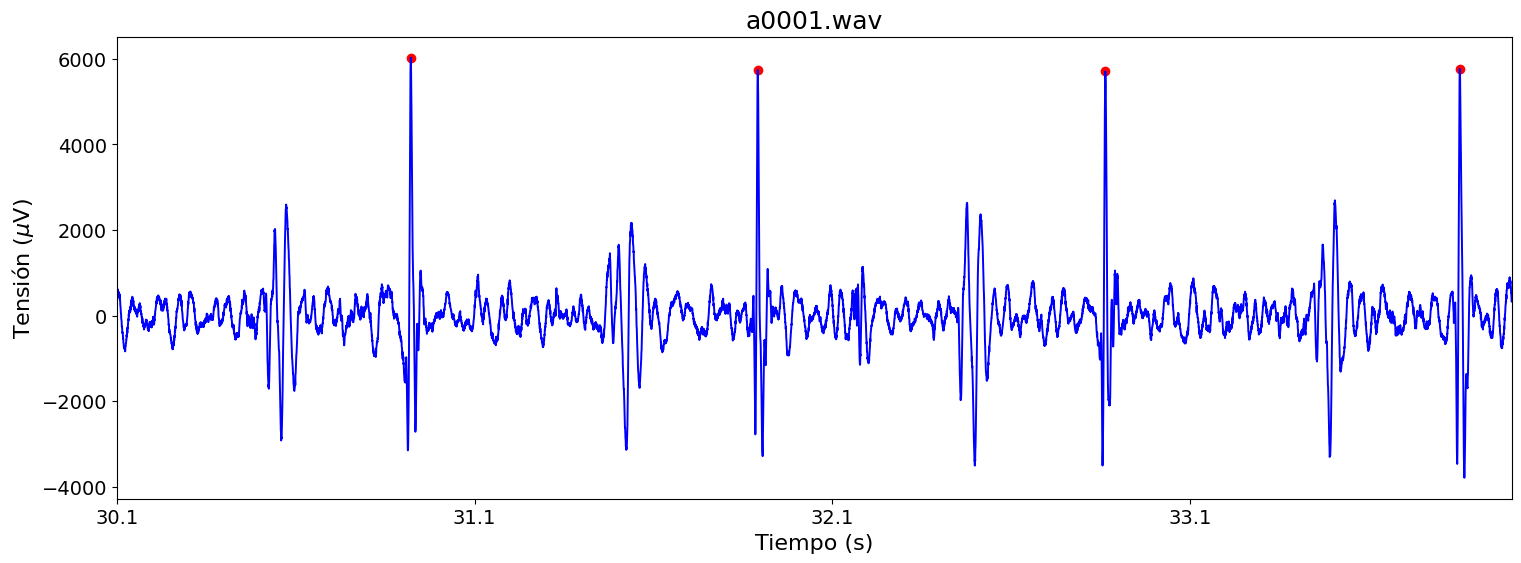

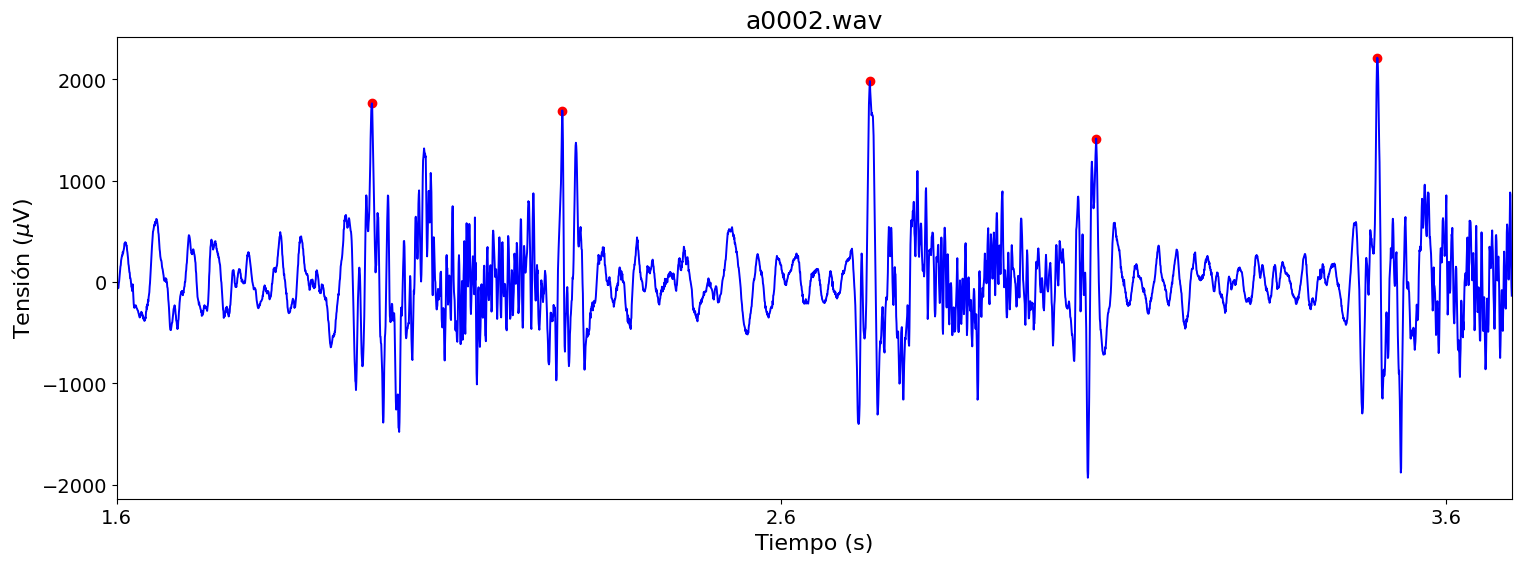

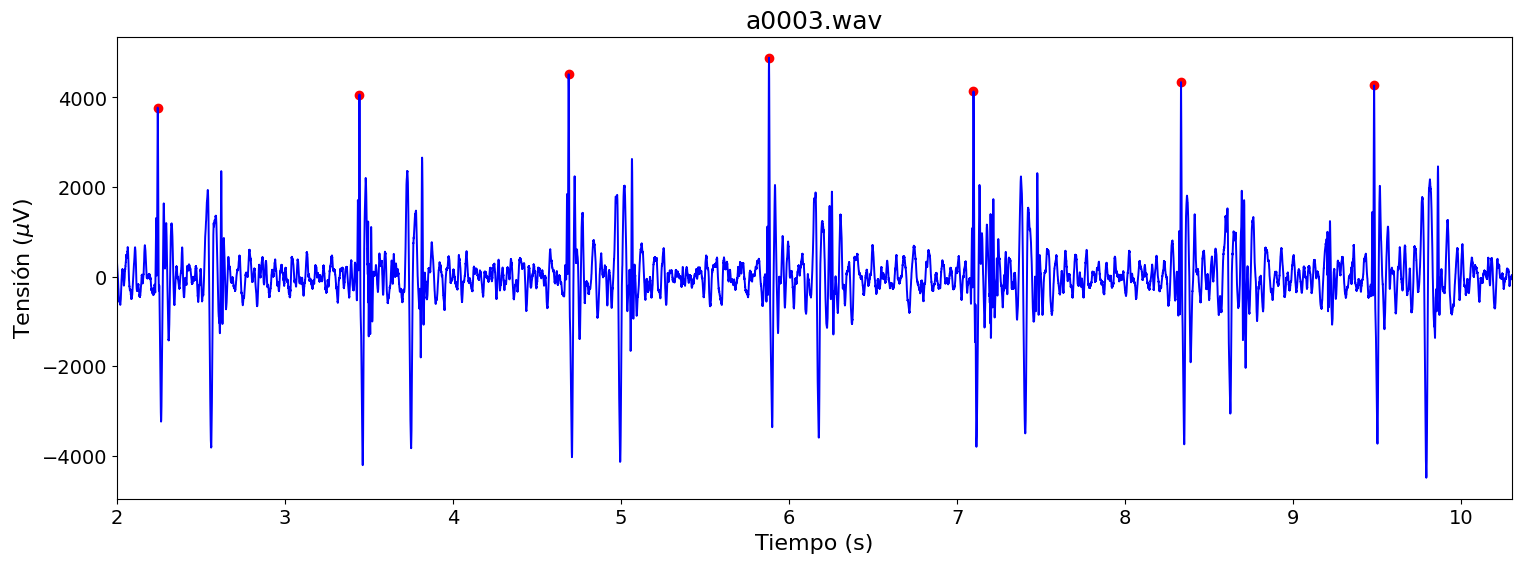

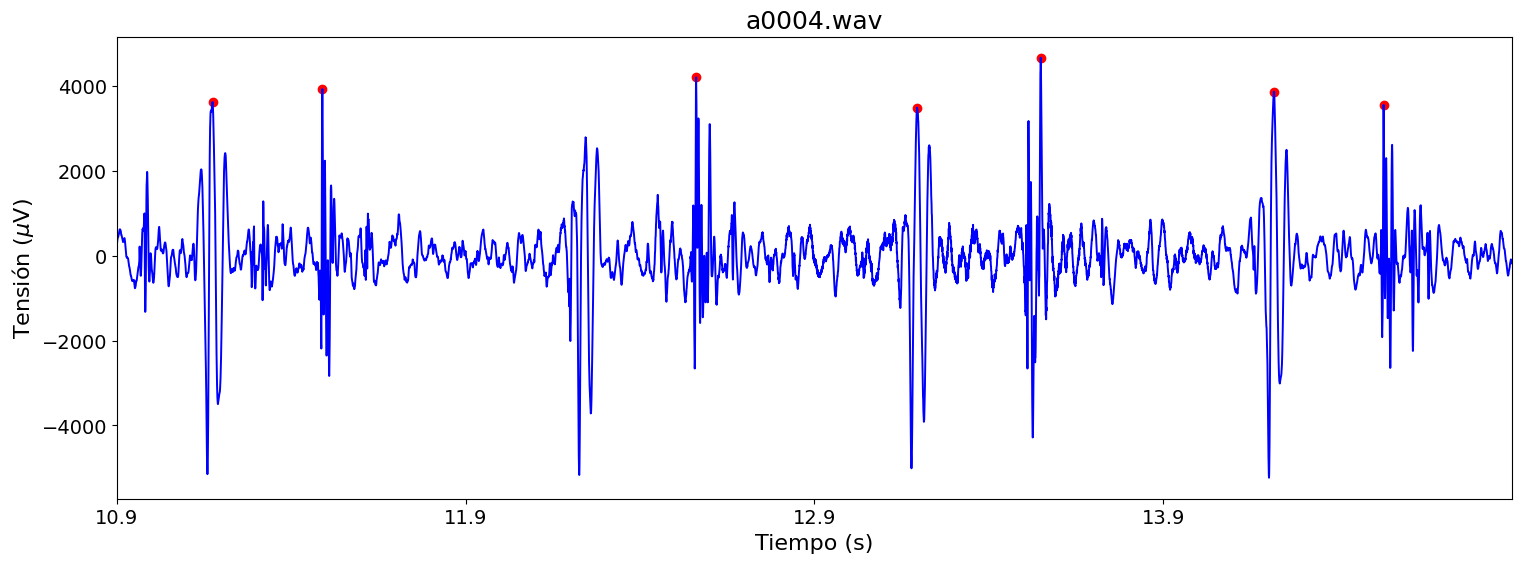

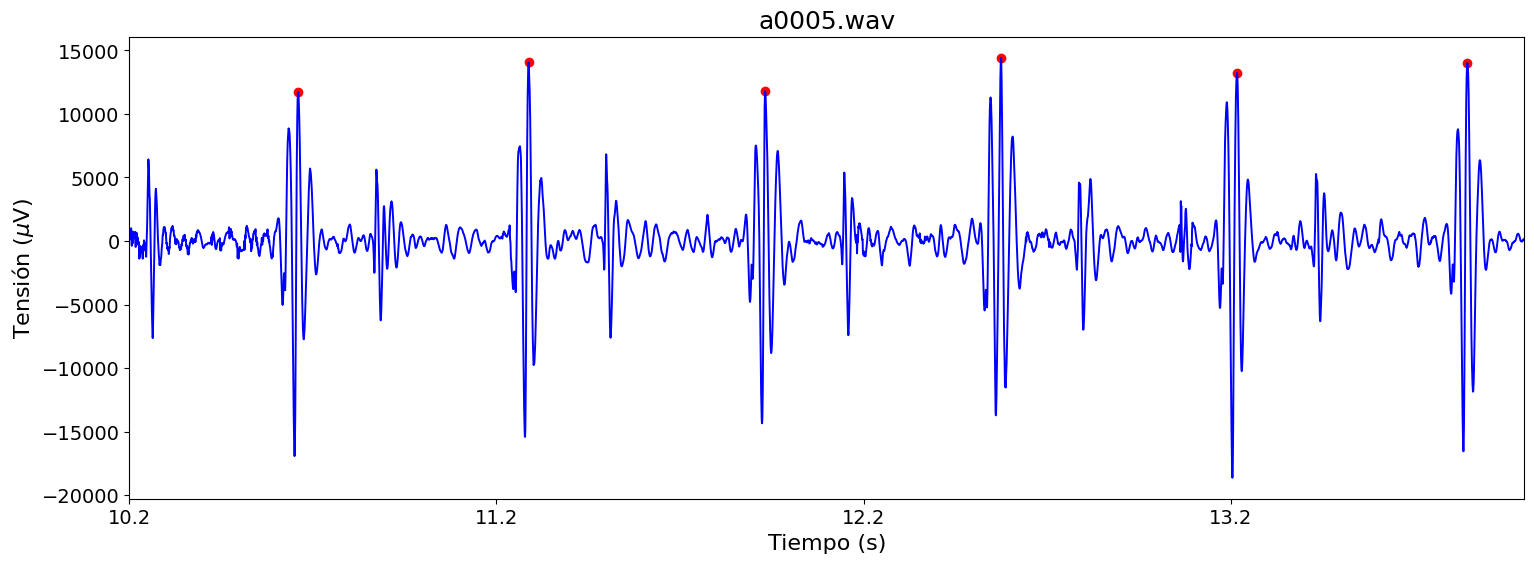

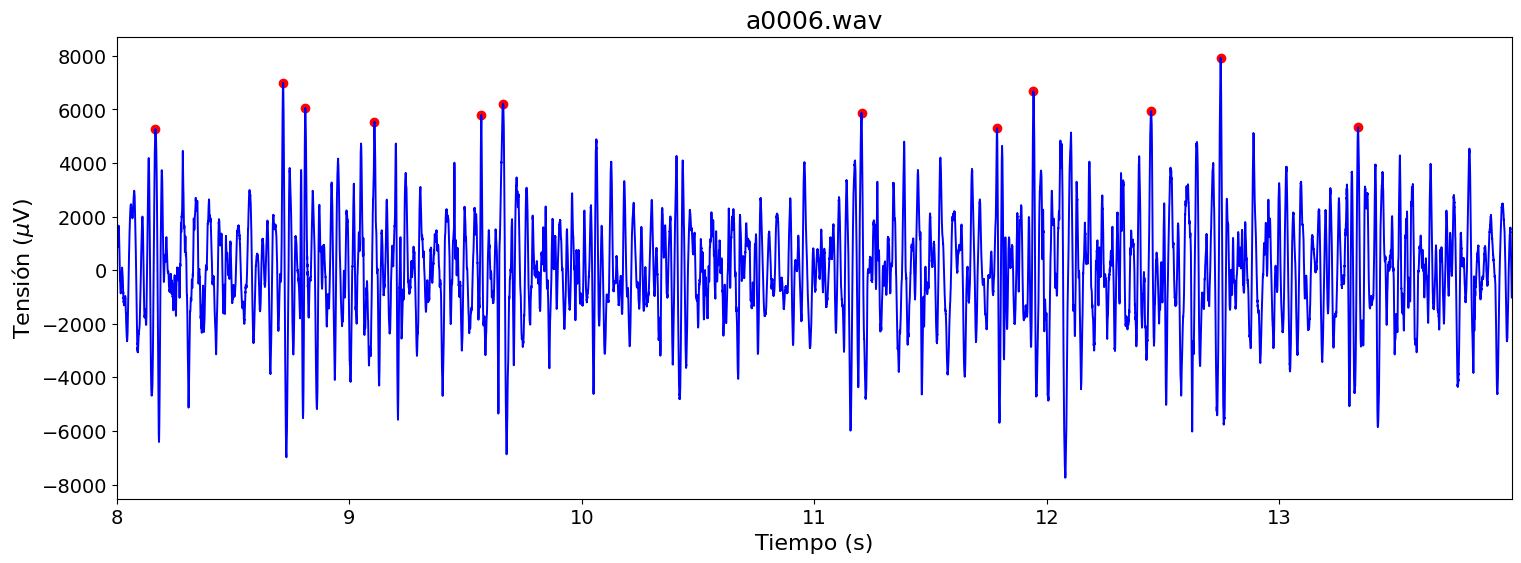

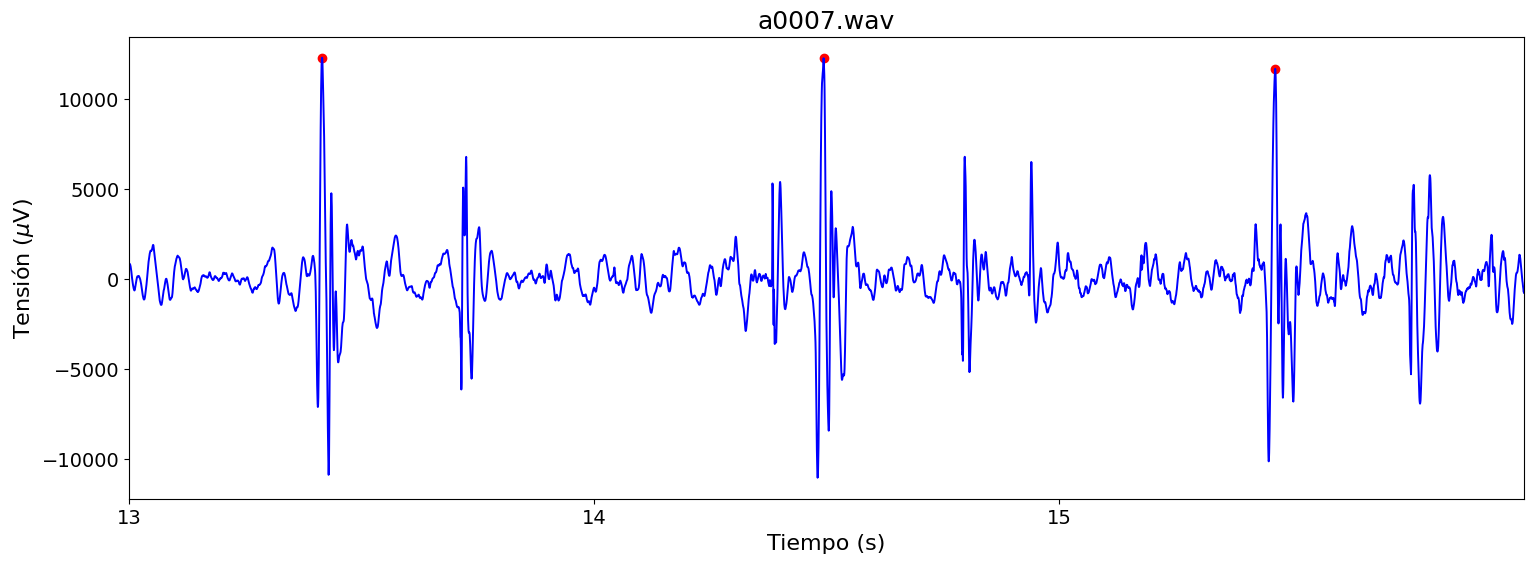

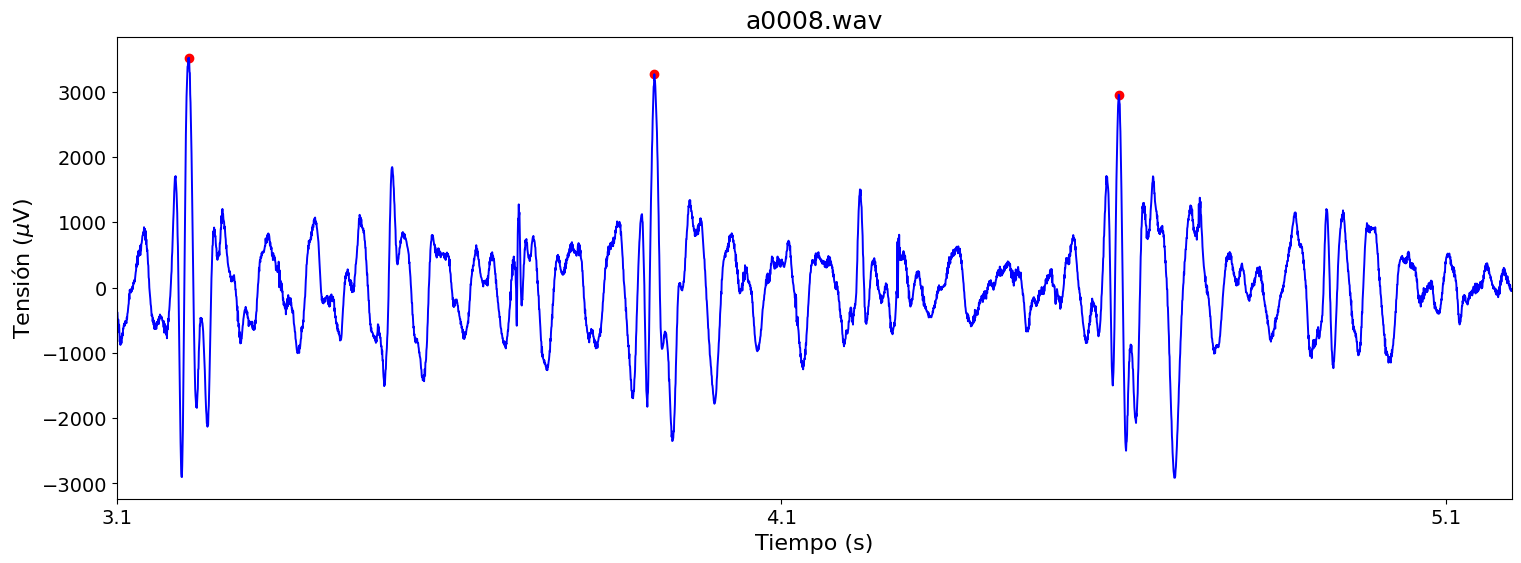

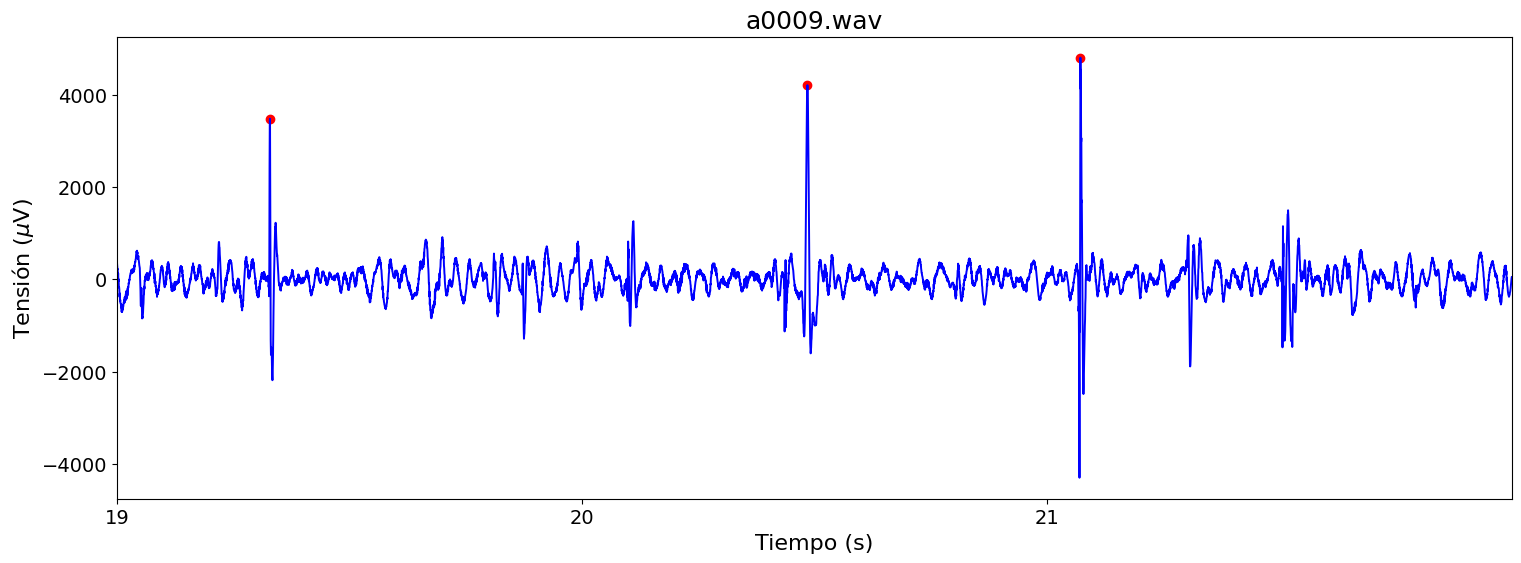

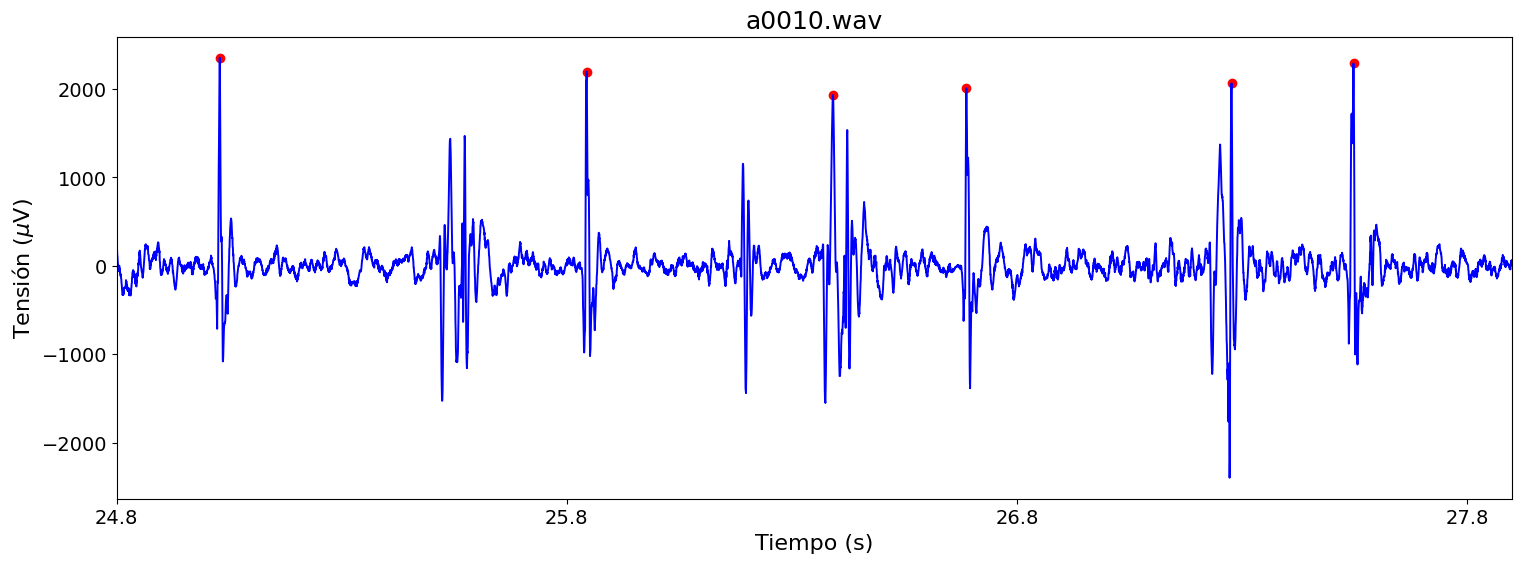

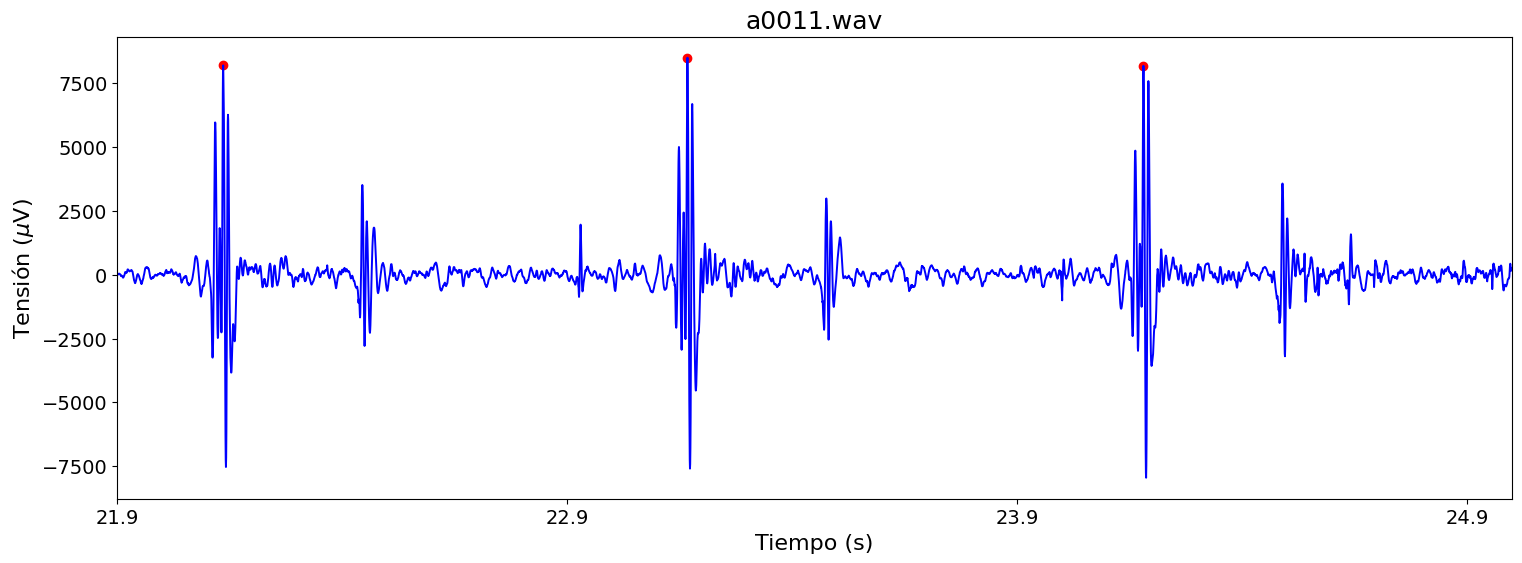

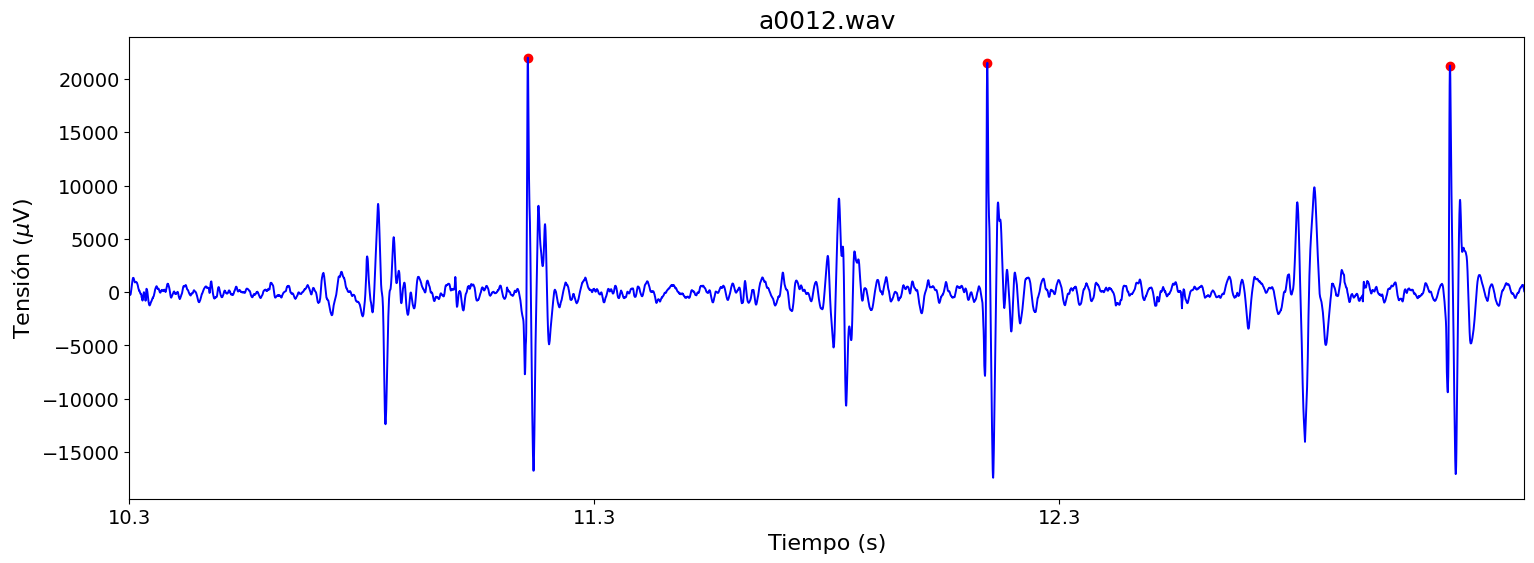

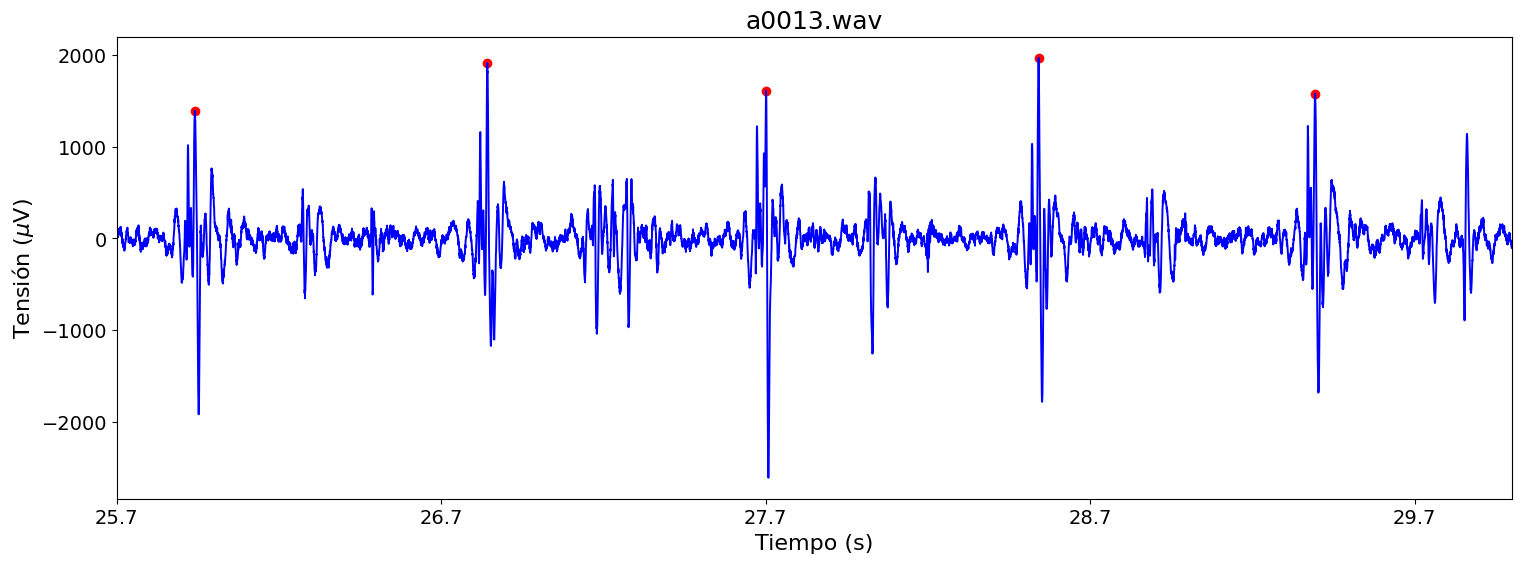

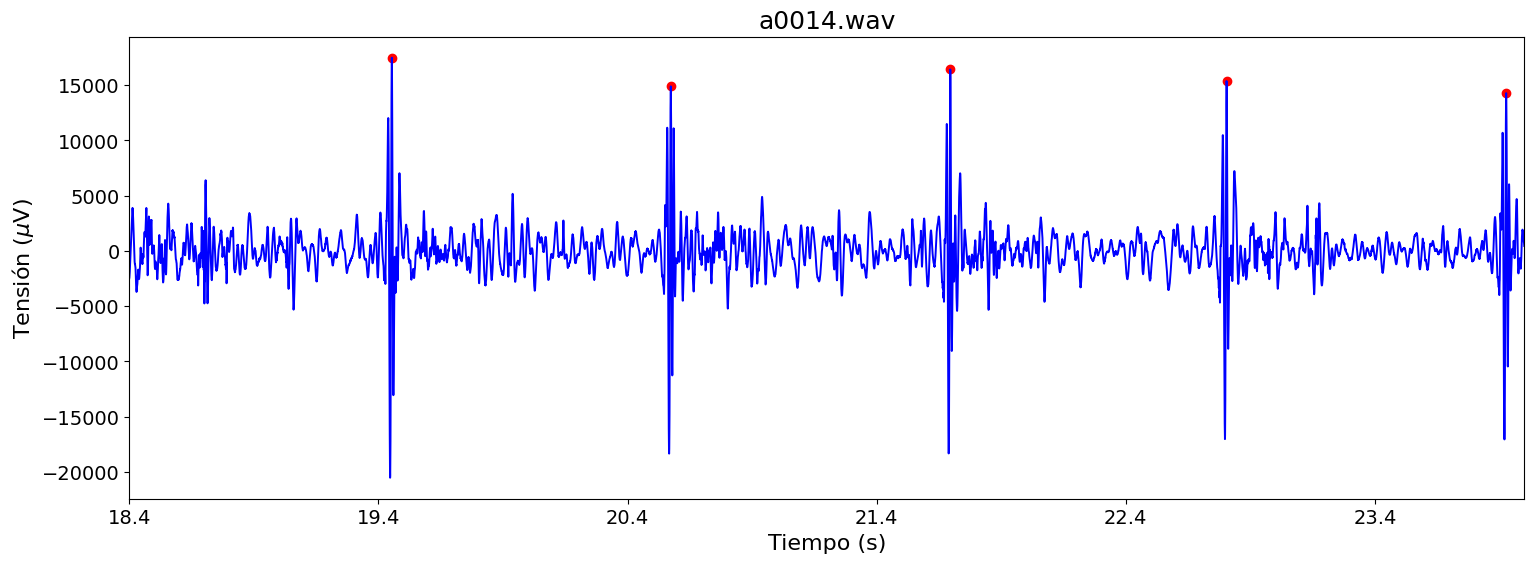

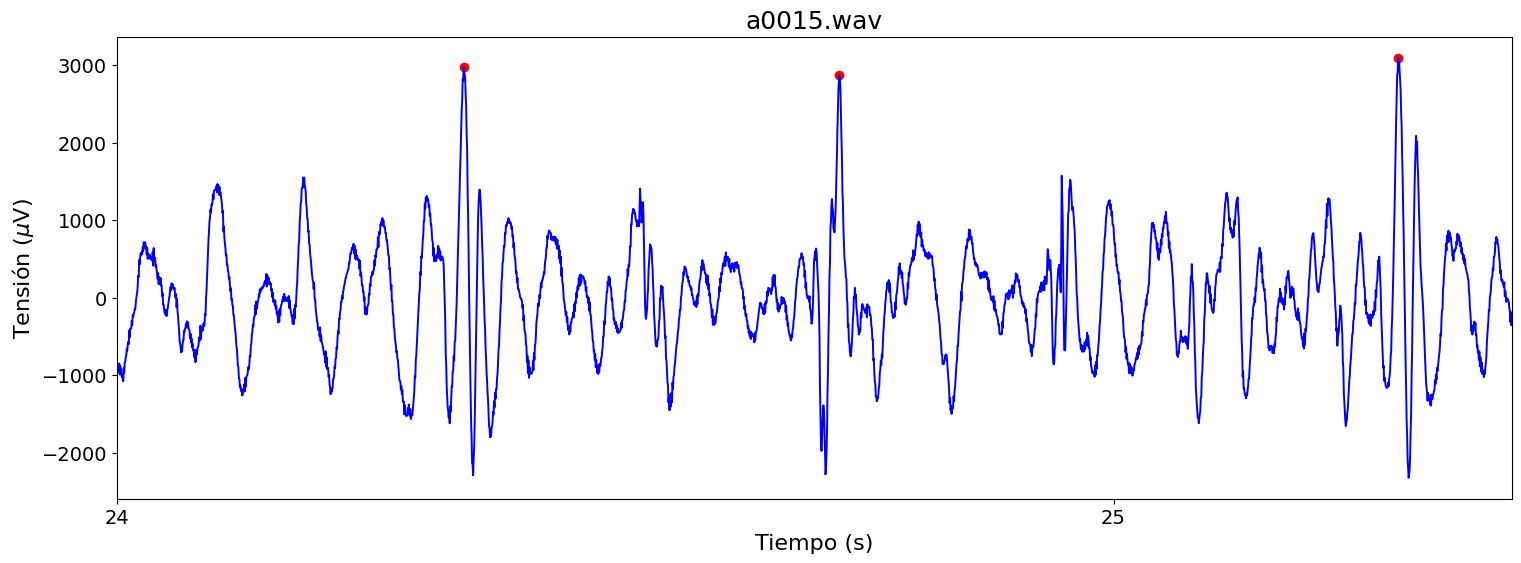

In [157]:
for i in range(0, len(ondas)):
    timeECG, waveData = ecg(ondas[i]+'.wav')
    timeECG, waveData = timeECG[n1[i]:n2[i]], waveData[n1[i]:n2[i]]
    plt.figure(figsize=(18,6))
    plt.xlabel(r'Tiempo (s)')
    plt.ylabel(r'Tensión ($\mu$V)')
    plt.plot(timeECG,waveData, 'b')
    plt.xlim(min(timeECG),max(timeECG))
    plt.title(ondas[i]+'.wav')
    plt.xticks(np.arange(min(timeECG),max(timeECG),1)) # Se agregan más marcas en el eje de tiempo.
    mxs_indices = detecta_maximos_locales(timeECG, waveData, threshold_ratio= t[i])
    plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
    plt.show()

# Ritmo cardiaco

Una vez se tienen los picos (R) de la señal, se puede obtener la frecuencia cardiaca y graficar un promedio de esta. 
####
Esta sección de código obtiene los datos de la señal, los recorta en el intervalo según los parámetros dados al incio, y con ellos calcula su frecuencia cardiaca promedio y puntos de frecuencia cardiaca. Finalmente, grafica estas características en términos de número de ciclo del electrocardiograma, empleando barras de error para mostrar el posible error del cálculo.  

Frecuencia cardiaca promedio de a0001.wav: 61.5454892809667


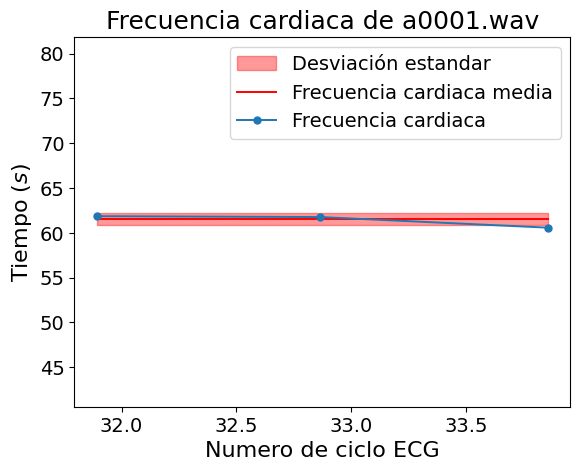

Frecuencia cardiaca promedio de a0002.wav: 142.88773437923905


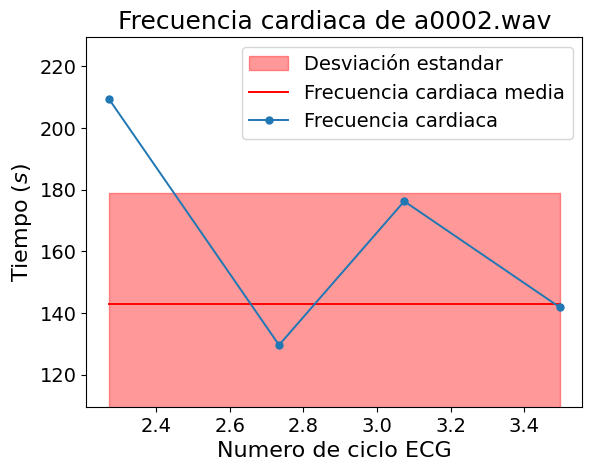

Frecuencia cardiaca promedio de a0003.wav: 50.604634503584556


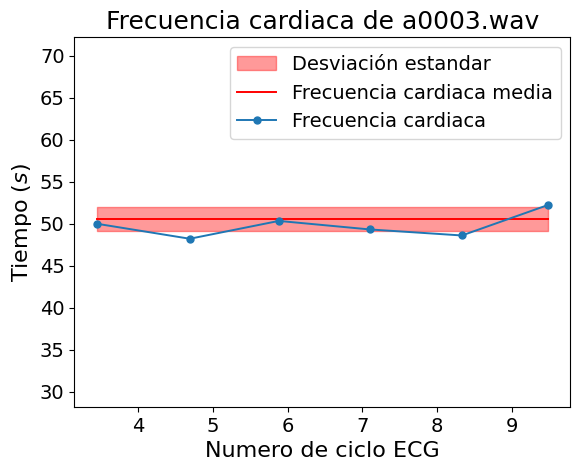

Frecuencia cardiaca promedio de a0004.wav: 105.01165159234725


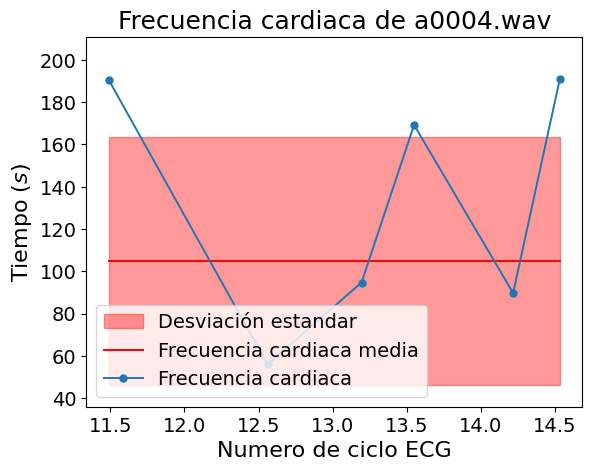

Frecuencia cardiaca promedio de a0005.wav: 94.74798083345041


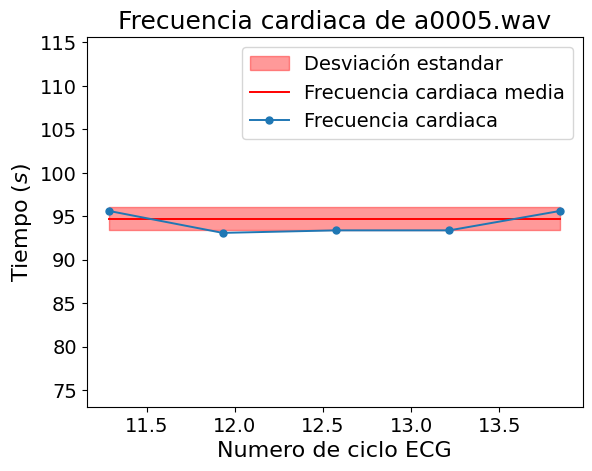

Frecuencia cardiaca promedio de a0006.wav: 120.00711027988785


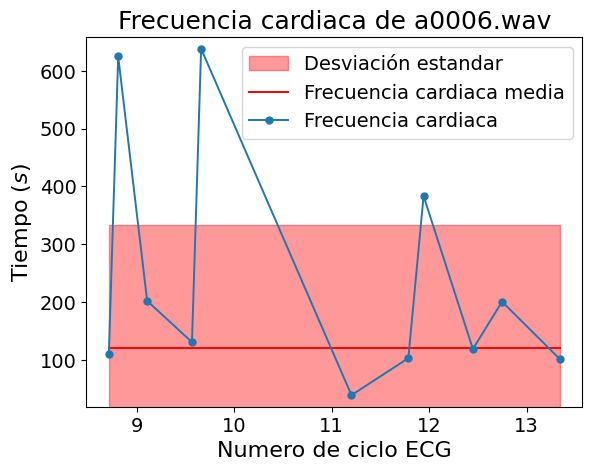

Frecuencia cardiaca promedio de a0007.wav: 60.00916038951405


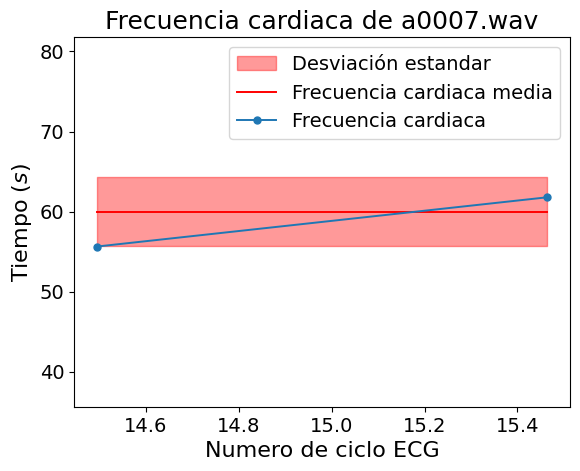

Frecuencia cardiaca promedio de a0008.wav: 85.73350150973286


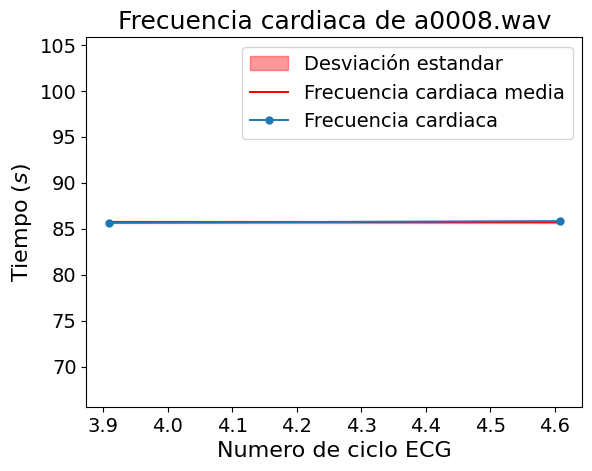

Frecuencia cardiaca promedio de a0009.wav: 60.00916366717253


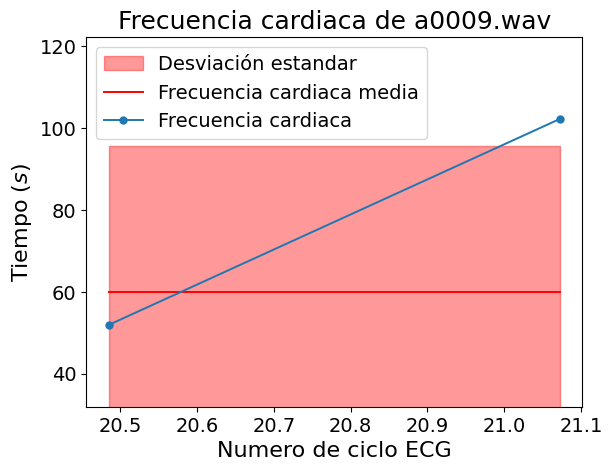

Frecuencia cardiaca promedio de a0010.wav: 116.14614068800076


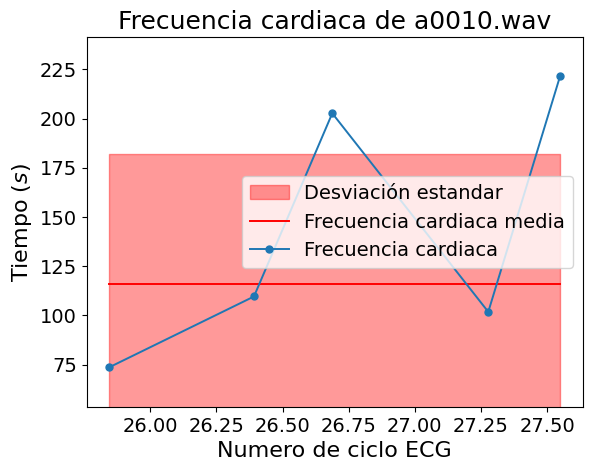

Frecuencia cardiaca promedio de a0011.wav: 58.073067159715976


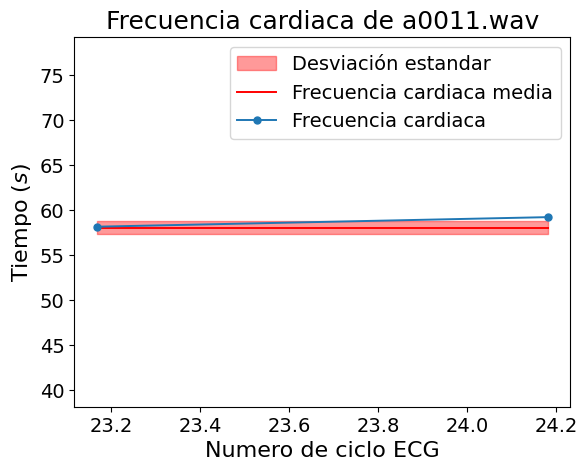

Frecuencia cardiaca promedio de a0012.wav: 60.00902935693192


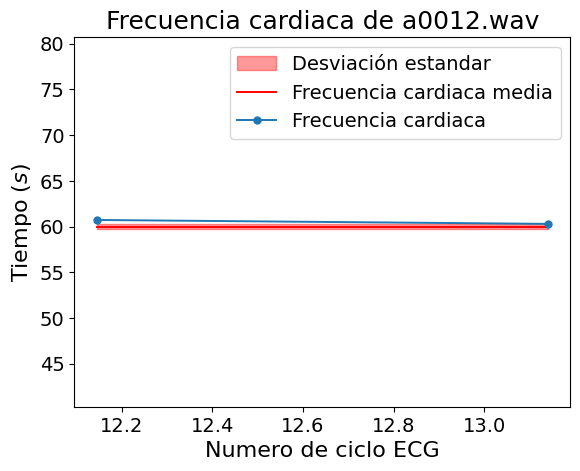

Frecuencia cardiaca promedio de a0013.wav: 69.77457711685368


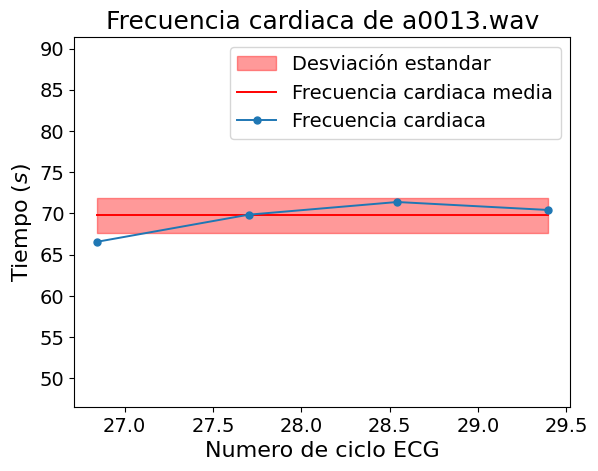

Frecuencia cardiaca promedio de a0014.wav: 53.575462550593535


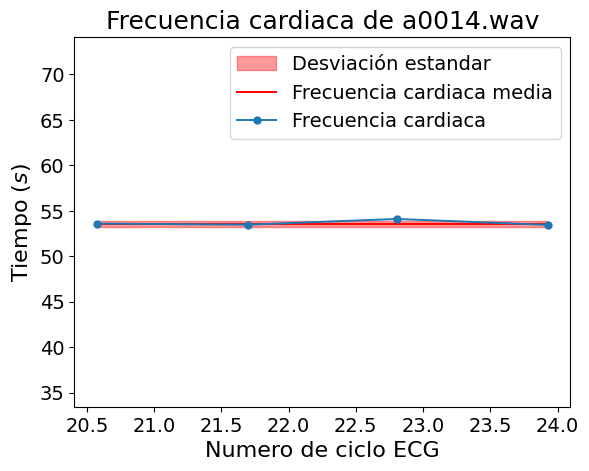

Frecuencia cardiaca promedio de a0015.wav: 128.6155637950906


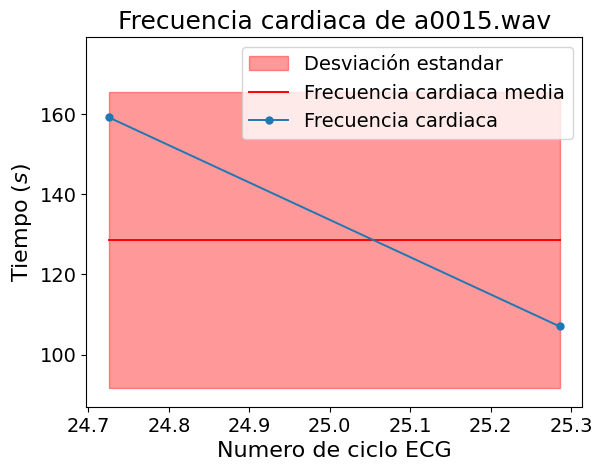

In [161]:
for i in range(0, len(ondas)):
    timeECG, waveData = ecg(ondas[i]+'.wav')
    timeECG, waveData = timeECG[n1[i]:n2[i]], waveData[n1[i]:n2[i]]
    mxs_indices = detecta_maximos_locales(timeECG, waveData, threshold_ratio= t[i])
    mean_bpm = 60*(len(mxs_indices)/(timeECG[-1]-timeECG[0]))
    print("Frecuencia cardiaca promedio de "+ondas[i]+'.wav:', mean_bpm)

    heart_rate = [(60/(timeECG[mxs_indices[i+1]]-timeECG[mxs_indices[i]])) \
              for i in range(0, len(mxs_indices)-1)]
    time = timeECG[mxs_indices]

    mean_vec = [mean_bpm for i in range(0, len(time)-1)]
    std_vec_plus = [mean_bpm+stdev(heart_rate) for i in range(0, len(time)-1)]
    std_vec_minus = [mean_bpm-stdev(heart_rate) for i in range(0, len(time)-1)]

    plt.fill_between(time[1:], std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Desviación estandar", color='red', alpha=0.4)
    plt.plot(time[1:], mean_vec, c="r", label = "Frecuencia cardiaca media")
    plt.plot(time[1:], heart_rate, markersize=5, marker = "o", label="Frecuencia cardiaca")
    plt.ylim((min(heart_rate)- 20, max(heart_rate) + 20))
    plt.title("Frecuencia cardiaca de " + ondas[i] + ".wav")
    plt.xlabel(r'Numero de ciclo ECG')
    plt.ylabel(r'Tiempo ($s$)')
    plt.legend()
    plt.show()

# Referencias
[1] Erin C. McKiernan Ana Daniela del Río Pulido. ECGAnalysis.ipynb. UNAM. url: https://gist.github.com/emckiernan/3e7e86a48256777e9e6a44ede032d938.
